In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.manifold import TSNE
from scipy.optimize import curve_fit
from scipy.stats import zscore, kstest
import scipy.io
import os


from functions import *

In [2]:
#Open multiple dataset from "./data/" folder
datasets = []
for file in os.listdir("data"):
    try:
        data = scipy.io.loadmat("./data/" + file)
        data = pd.DataFrame(data["tseries"].T)
        datasets.append(data)
    except:
        print("Problem with \"" + str(file) + "\" file")

print("Uploaded " + str(len(datasets)) + " file")

Uploaded 96 file


In [3]:
#Load MINDy parameters
Ws = scipy.io.loadmat("./MINDy_parameters/W.mat")["Ws"][0]
alphas = scipy.io.loadmat("./MINDy_parameters/alpha.mat")["alphas"][0]
Ds = scipy.io.loadmat("./MINDy_parameters/D.mat")["Ds"][0]
b = 6.666666666666667

In [4]:
#Load parameters by index
def load_param(idx, datasets=datasets, Ws=Ws, alphas=alphas, Ds=Ds):
    data = datasets[idx]
    W = Ws[idx]
    alpha = alphas[idx]
    D = Ds[idx]
    alpha = alpha[:, 0]
    D = D[:, 0]

    return data, W, alpha, D

In [5]:
full_FC = lambda df : df.corr("pearson").values

In [6]:
#To get LaTeX style
def LaTeX_mode(): 
    plt.rcParams['text.usetex'] = True
    #plt.style.use("default")
    #plt.rc("text", usetex=True)
    #plt.rc("font", family="cm")

LaTeX_mode()

## Intro and methods

In [43]:
df = datasets[42]
df.head(2)

0             1             2             3             4    \
0  13606.840820  11455.109375  12262.004883  11215.610352  11966.733398   
1  13647.695312  11469.314453  12297.188477  11197.331055  11972.578125   

            5             6             7             8             9    ...  \
0  12562.048828  10902.959961  11668.788086  11763.152344  10539.632812  ...   
1  12550.421875  10847.571289  11627.028320  11756.225586  10476.580078  ...   

            109           110           111           112          113  \
0  12052.589813  11659.469098  13115.111432  12563.999273  8992.183061   
1  12086.164724  11751.251139  13179.088580  12487.299190  8977.902742   

           114           115           116           117           118  
0  8046.903598  11471.238592  11120.265260  12972.743957  11682.879845  
1  8029.804265  11446.884261  11129.236809  12942.267553  11648.945492  

[2 rows x 119 columns]

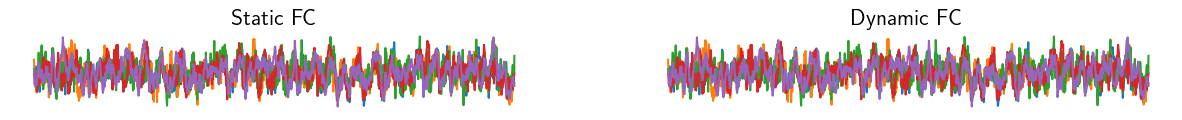

In [16]:
df = zscore(datasets[42])

plt.figure(figsize=(15, 1))
plt.subplot(121)
plt.title("Static FC", fontsize=16)
plt.axis("off")

x = np.arange(len(df[0]))
for i in range(1, 100, 20):
    plt.plot(x, df[i])

plt.subplot(122)
plt.title("Dynamic FC", fontsize=16)
plt.axis("off")

x = np.arange(len(df[0]))
for i in range(1, 100, 20):
    plt.plot(x, df[i])


(0.0, 119.0, 119.0, 0.0)

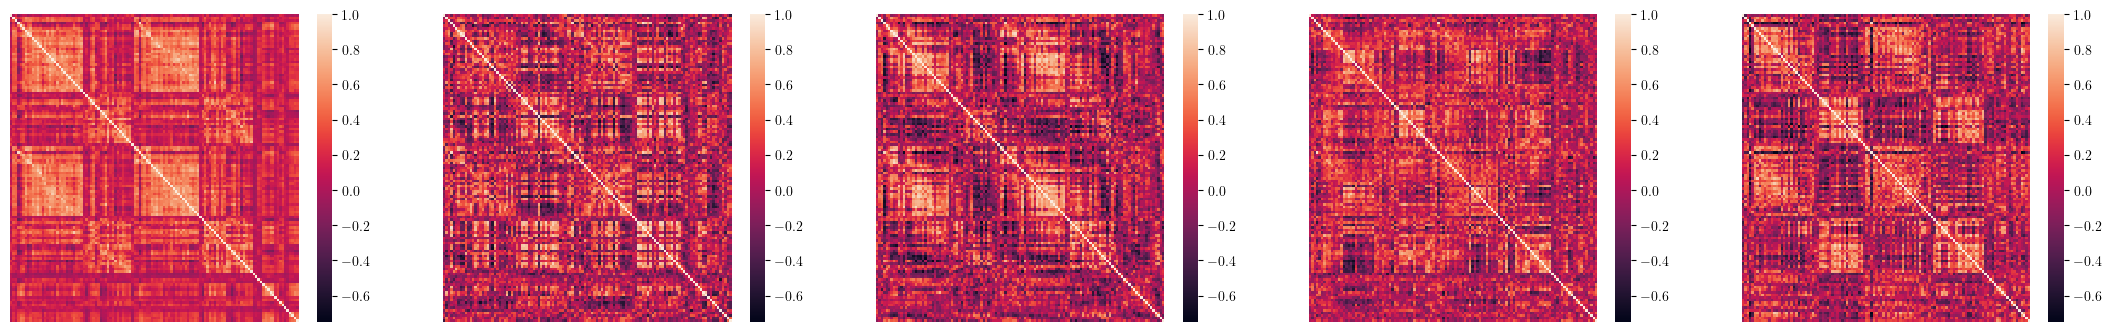

In [18]:
df = datasets[0]
s = dFC_stream(df, 30)

plt.figure(figsize=(27, 4))

plt.subplot(151)
sn.heatmap(full_FC(df), vmin=-0.75, vmax=1)
plt.axis("off")

plt.subplot(152)
sn.heatmap(s[1], vmin=-0.75, vmax=1)
plt.axis("off")

plt.subplot(153)
sn.heatmap(s[3], vmin=-0.75, vmax=1)
plt.axis("off")

plt.subplot(154)
sn.heatmap(s[5], vmin=-0.75, vmax=1)
plt.axis("off")

plt.subplot(155)
sn.heatmap(s[7], vmin=-0.75, vmax=1)
plt.axis("off")


Text(109.92267123557924, 0.5, '$FC(t_2)$')

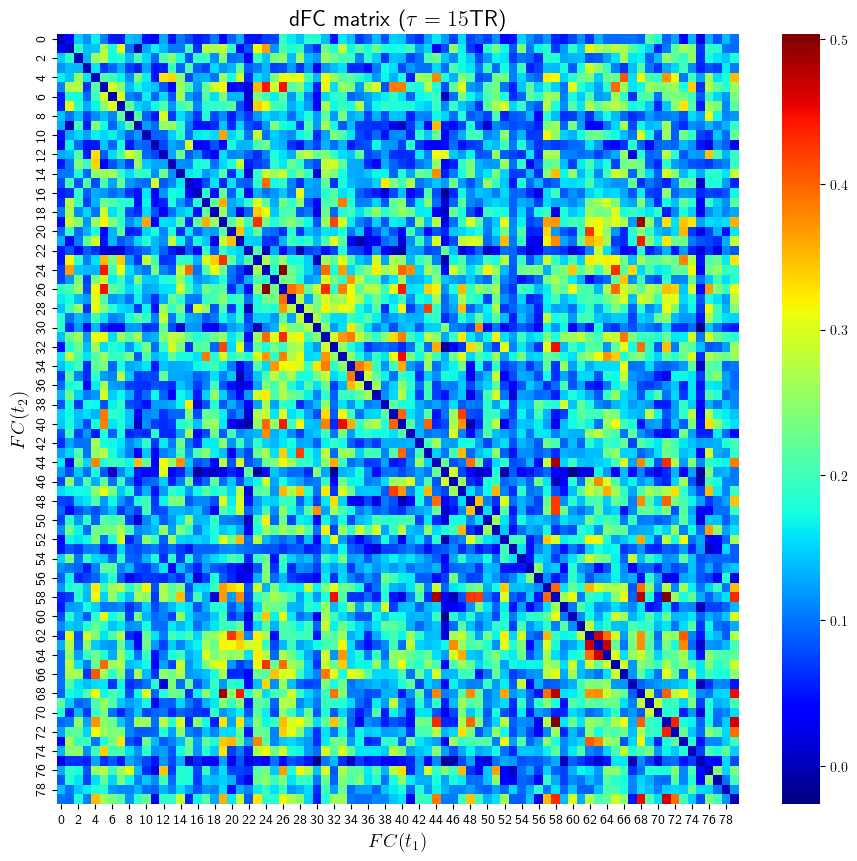

In [39]:
s = dFC_stream(df, 15)
m = dFC_matrix(s)
plt.figure(figsize=(11, 10))
plt.title(r"dFC matrix ($\tau = 15$TR)", fontsize=16)
sn.heatmap(m - np.diag(np.diag(m)), cmap="jet")
plt.xlabel(r"$FC(t_1)$", fontsize=14)
plt.ylabel(r"$FC(t_2)$", fontsize=14)
#plt.tight_layout

Text(794.0135803264882, 0.5, 'Brain regions')

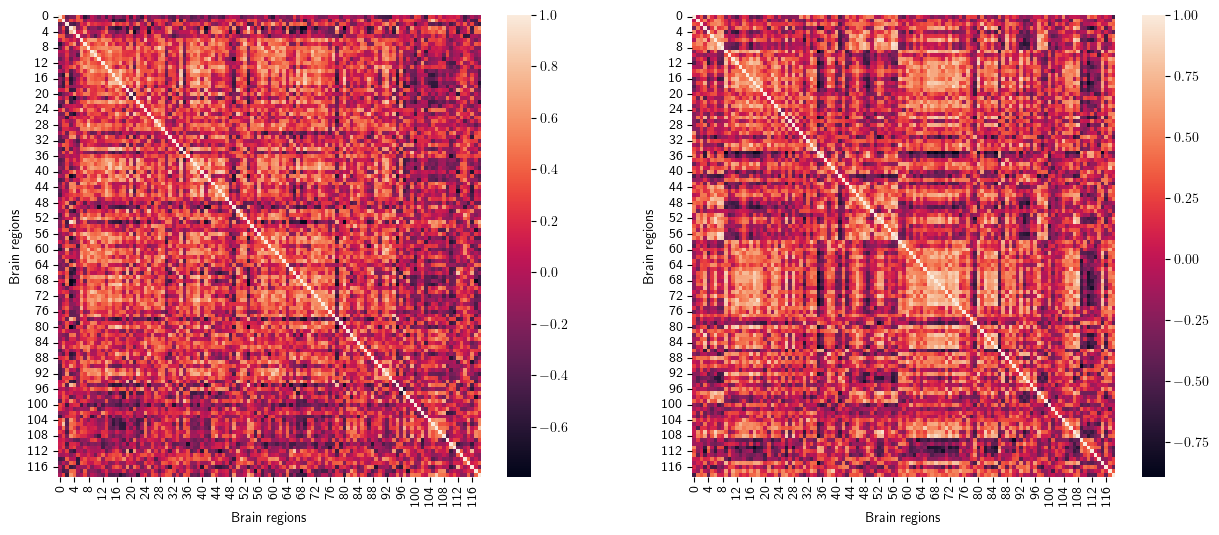

In [45]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
sn.heatmap(s[10])
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")

plt.subplot(122)
sn.heatmap(s[2])
plt.xlabel("Brain regions")
plt.ylabel("Brain regions")


## V distribution

CPU times: total: 1.12 s
Wall time: 5.08 s


<AxesSubplot: title={'center': 'dFC matrix | $\\tau=90$TR'}>

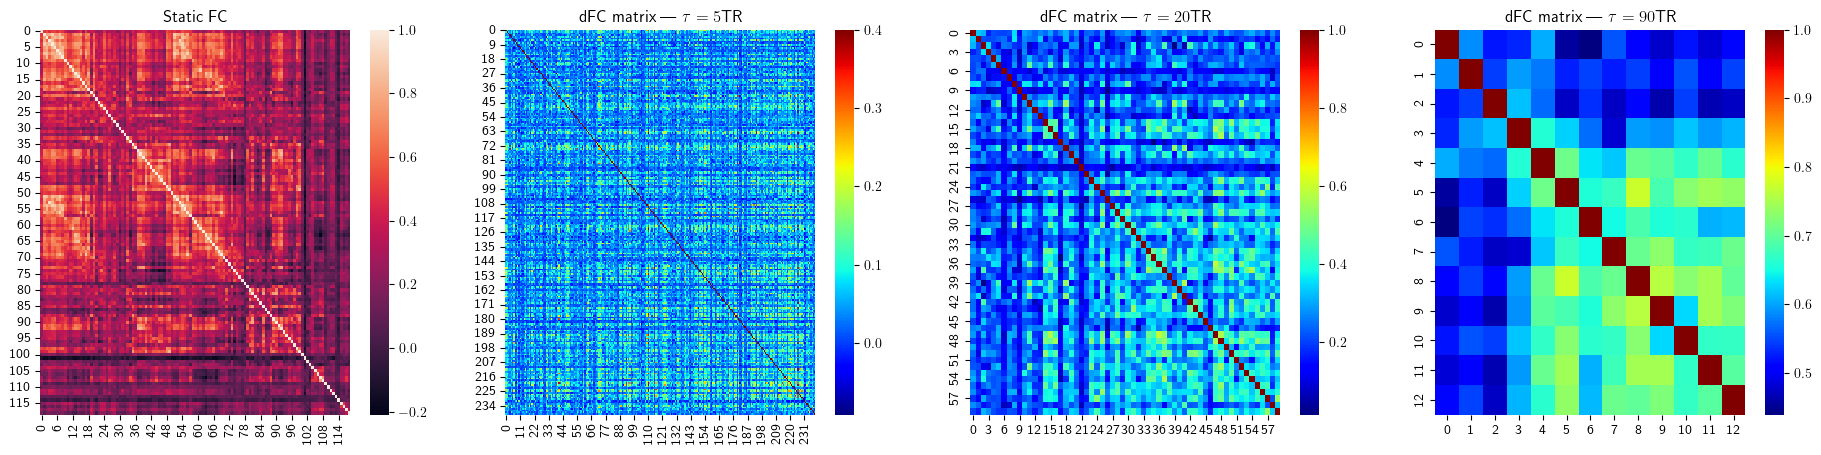

In [46]:
%%time
df = datasets[42]

plt.figure(figsize=(23, 5))

plt.subplot(141)
plt.title("Static FC")
sn.heatmap(full_FC(df))

plt.subplot(142)
plt.title(r"dFC matrix | $\tau=5$TR")
stream = dFC_stream(df, tau=5)
sn.heatmap(dFC_matrix(stream), cmap="jet", vmax=0.4)

plt.subplot(143)
plt.title(r"dFC matrix | $\tau=20$TR")
stream = dFC_stream(df, tau=20)
sn.heatmap(dFC_matrix(stream), cmap="jet")

plt.subplot(144)
plt.title(r"dFC matrix | $\tau=90$TR")
stream = dFC_stream(df, tau=90)
sn.heatmap(dFC_matrix(stream), cmap="jet")

In [47]:
#If TR=720ms
short_window = (8, 20)         #(6, 15)s
mid_window = (21, 82)          #(15, 60)s
long_window = (83, 290)        #(60, 210)s

In [48]:
%%time
short_range = np.array([])
mid_range = np.array([])
long_range = np.array([])

for subject in datasets:
    v_subject = pooled_v_stream(subject, short_window[0], short_window[1])
    short_range = np.concatenate((short_range, v_subject))

    v_subject = pooled_v_stream(subject, mid_window[0], mid_window[1])
    mid_range = np.concatenate((mid_range, v_subject))

    v_subject = pooled_v_stream(subject, long_window[0], long_window[1])
    long_range = np.concatenate((long_range, v_subject))

KeyboardInterrupt: 

CPU times: total: 1.72 s
Wall time: 8.45 s


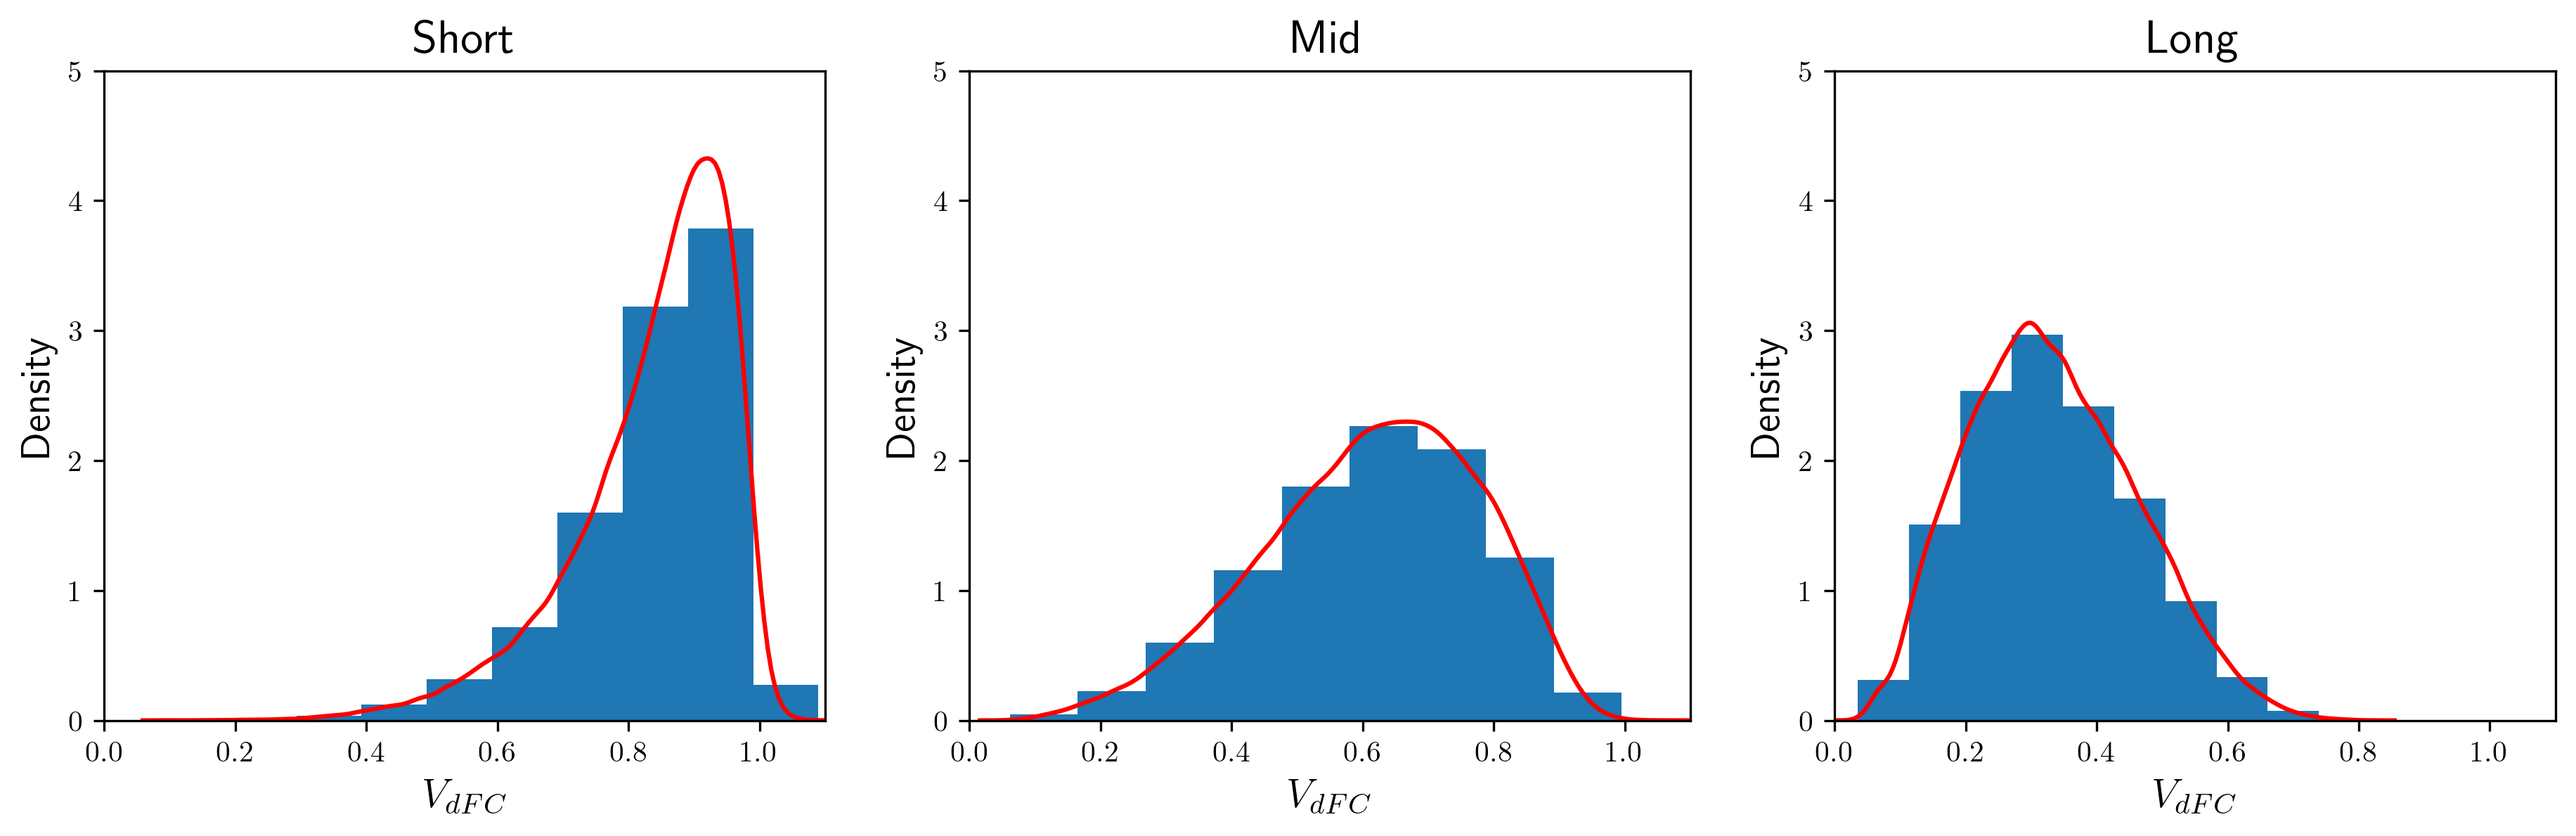

In [ ]:
%%time
plt.figure(figsize=(15, 4), dpi=300)
plt.subplot(131)
plt.title("Short", fontsize=16)
plt.xlabel(r"$V_{dFC}$", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.hist(short_range, density=True)
sn.kdeplot(short_range, color="red")
plt.ylim((0, 5))
plt.xlim((0, 1.1))

plt.subplot(132)
plt.title("Mid", fontsize=16)
plt.xlabel(r"$V_{dFC}$", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.hist(mid_range, density=True)
sn.kdeplot(mid_range, color="red")
plt.ylim((0, 5))
plt.xlim((0, 1.1))

plt.subplot(133)
plt.title("Long", fontsize=16)
plt.xlabel(r"$V_{dFC}$", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.hist(long_range, density=True)
sn.kdeplot(long_range, color="red")
plt.ylim((0, 5))
plt.xlim((0, 1.1))

#plt.savefig("./plots/v_dist2.png")

CPU times: total: 1.75 s
Wall time: 3.01 s


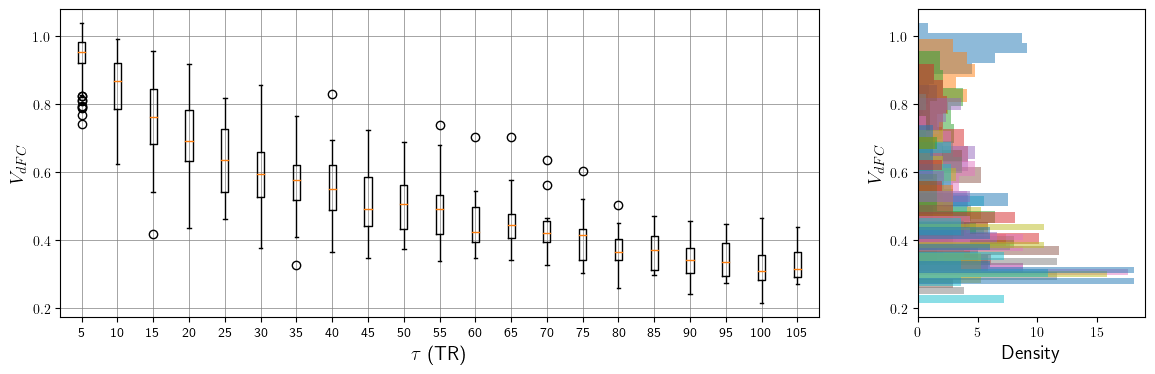

In [8]:
%%time

#Tau dependency in speed distribution
f, (a0, a1) = plt.subplots(1, 2, width_ratios=[4, 1.2], figsize=(14, 4))
a0.set_xlim([2, 108])
a0.set_xlabel(r"$\tau$ (TR)", fontsize=14)
a0.set_ylabel(r"$V_{dFC}$" , fontsize=14)
a0.grid(True)
a0.grid(color='gray', linestyle='-', linewidth=0.5)
a1.set_ylabel(r"$V_{dFC}$", fontsize=14)
a1.set_xlabel("Density", fontsize=14)

df = datasets[42]
for i in np.arange(5, 106, 5):
    #Get v_dist with tau=i
    v_i = pooled_v_stream(df, i, i)
    
    #Plot v(t) and hist(v)
    a0.boxplot(v_i, positions=[i], widths=1)
    a1.hist(v_i, orientation='horizontal', alpha=0.5, density=True)


#plt.savefig("./plots/tau_dependence.png")

## MINDy

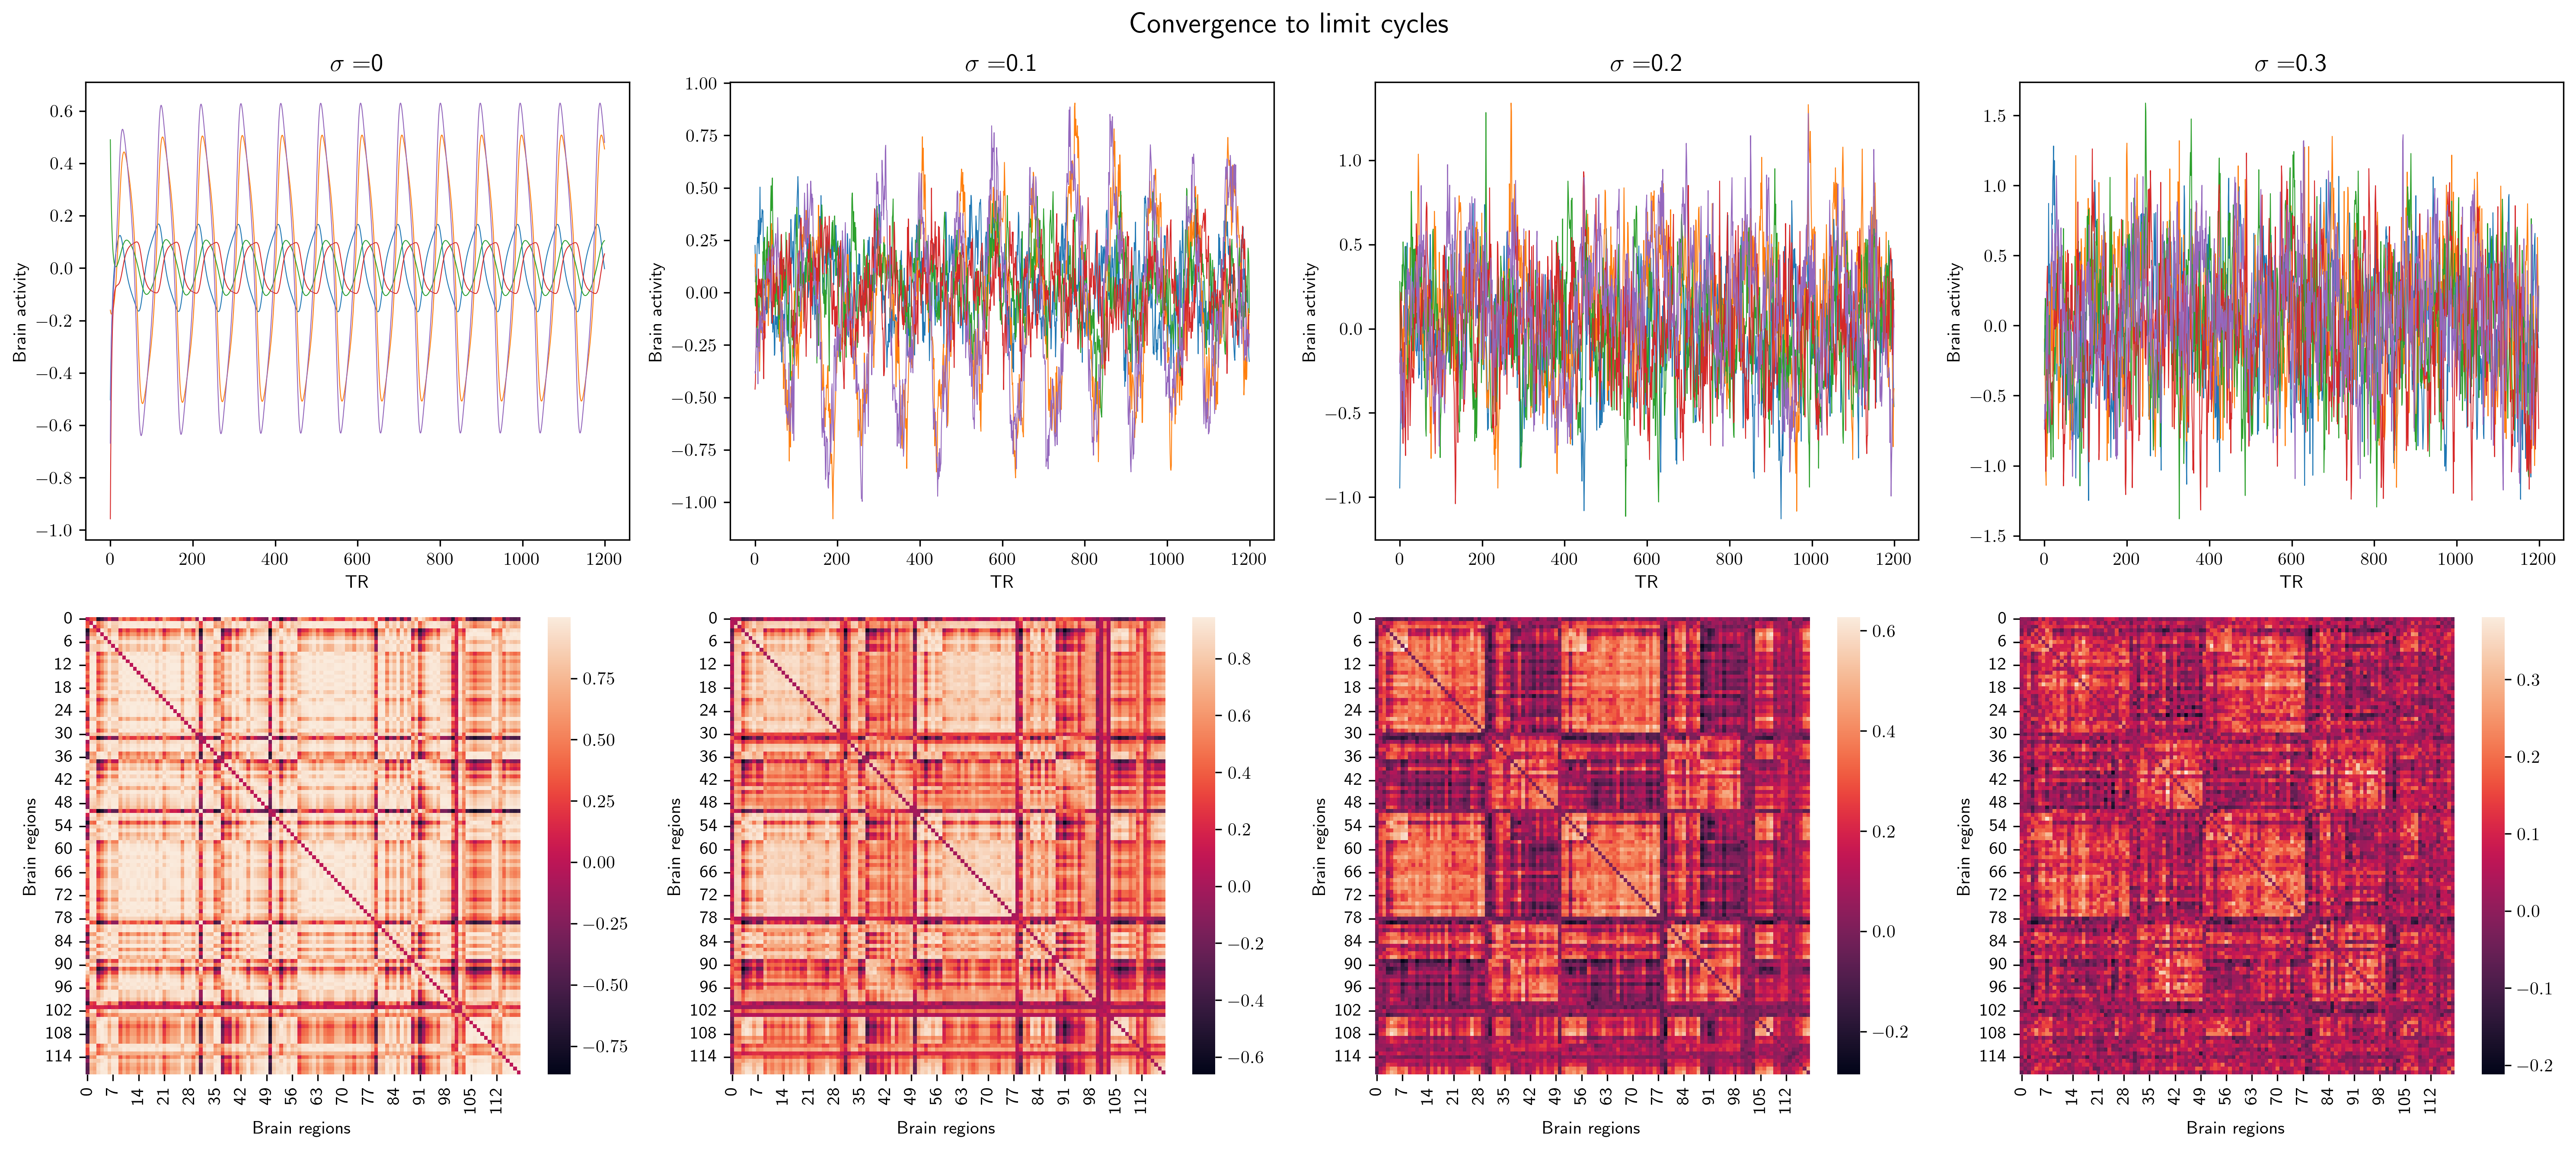

In [12]:
#Plot: simulation, FC, dFC
data, W, alpha, D = load_param(0)
sigma = [0, 0.1, 0.2, 0.3]

plt.figure(figsize=(20, 9), dpi=300)
plt.suptitle("Convergence to limit cycles", fontsize=16)
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.title("$\sigma = $" + str(sigma[i]), fontsize=14)
    plt.xlabel("TR")
    plt.ylabel("Brain activity")
    simul = propagation(W, alpha, D, sigma[i])
    plt.plot(np.arange(len(simul[0])), simul[0], lw=0.5)
    plt.plot(np.arange(len(simul[20])), simul[20], lw=0.5)
    plt.plot(np.arange(len(simul[30])), simul[30], lw=0.5)
    plt.plot(np.arange(len(simul[100])), simul[100], lw=0.5)
    plt.plot(np.arange(len(simul[60])), simul[60], lw=0.5)

    plt.subplot(2, 4, i+5)
    stream = dFC_stream(simul, 15)
    max_values = [0.8, 0.82, 0.65, 0.4]
    min_values = [-0.6, -0.65, -0.45, -0.2]
    #sn.heatmap(full_FC(simul), vmin=min_values[i], vmax=max_values[i])
    sn.heatmap(full_FC(simul)-np.diag(np.diag(full_FC(simul))))
    plt.xlabel("Brain regions")
    plt.ylabel("Brain regions")

plt.tight_layout()

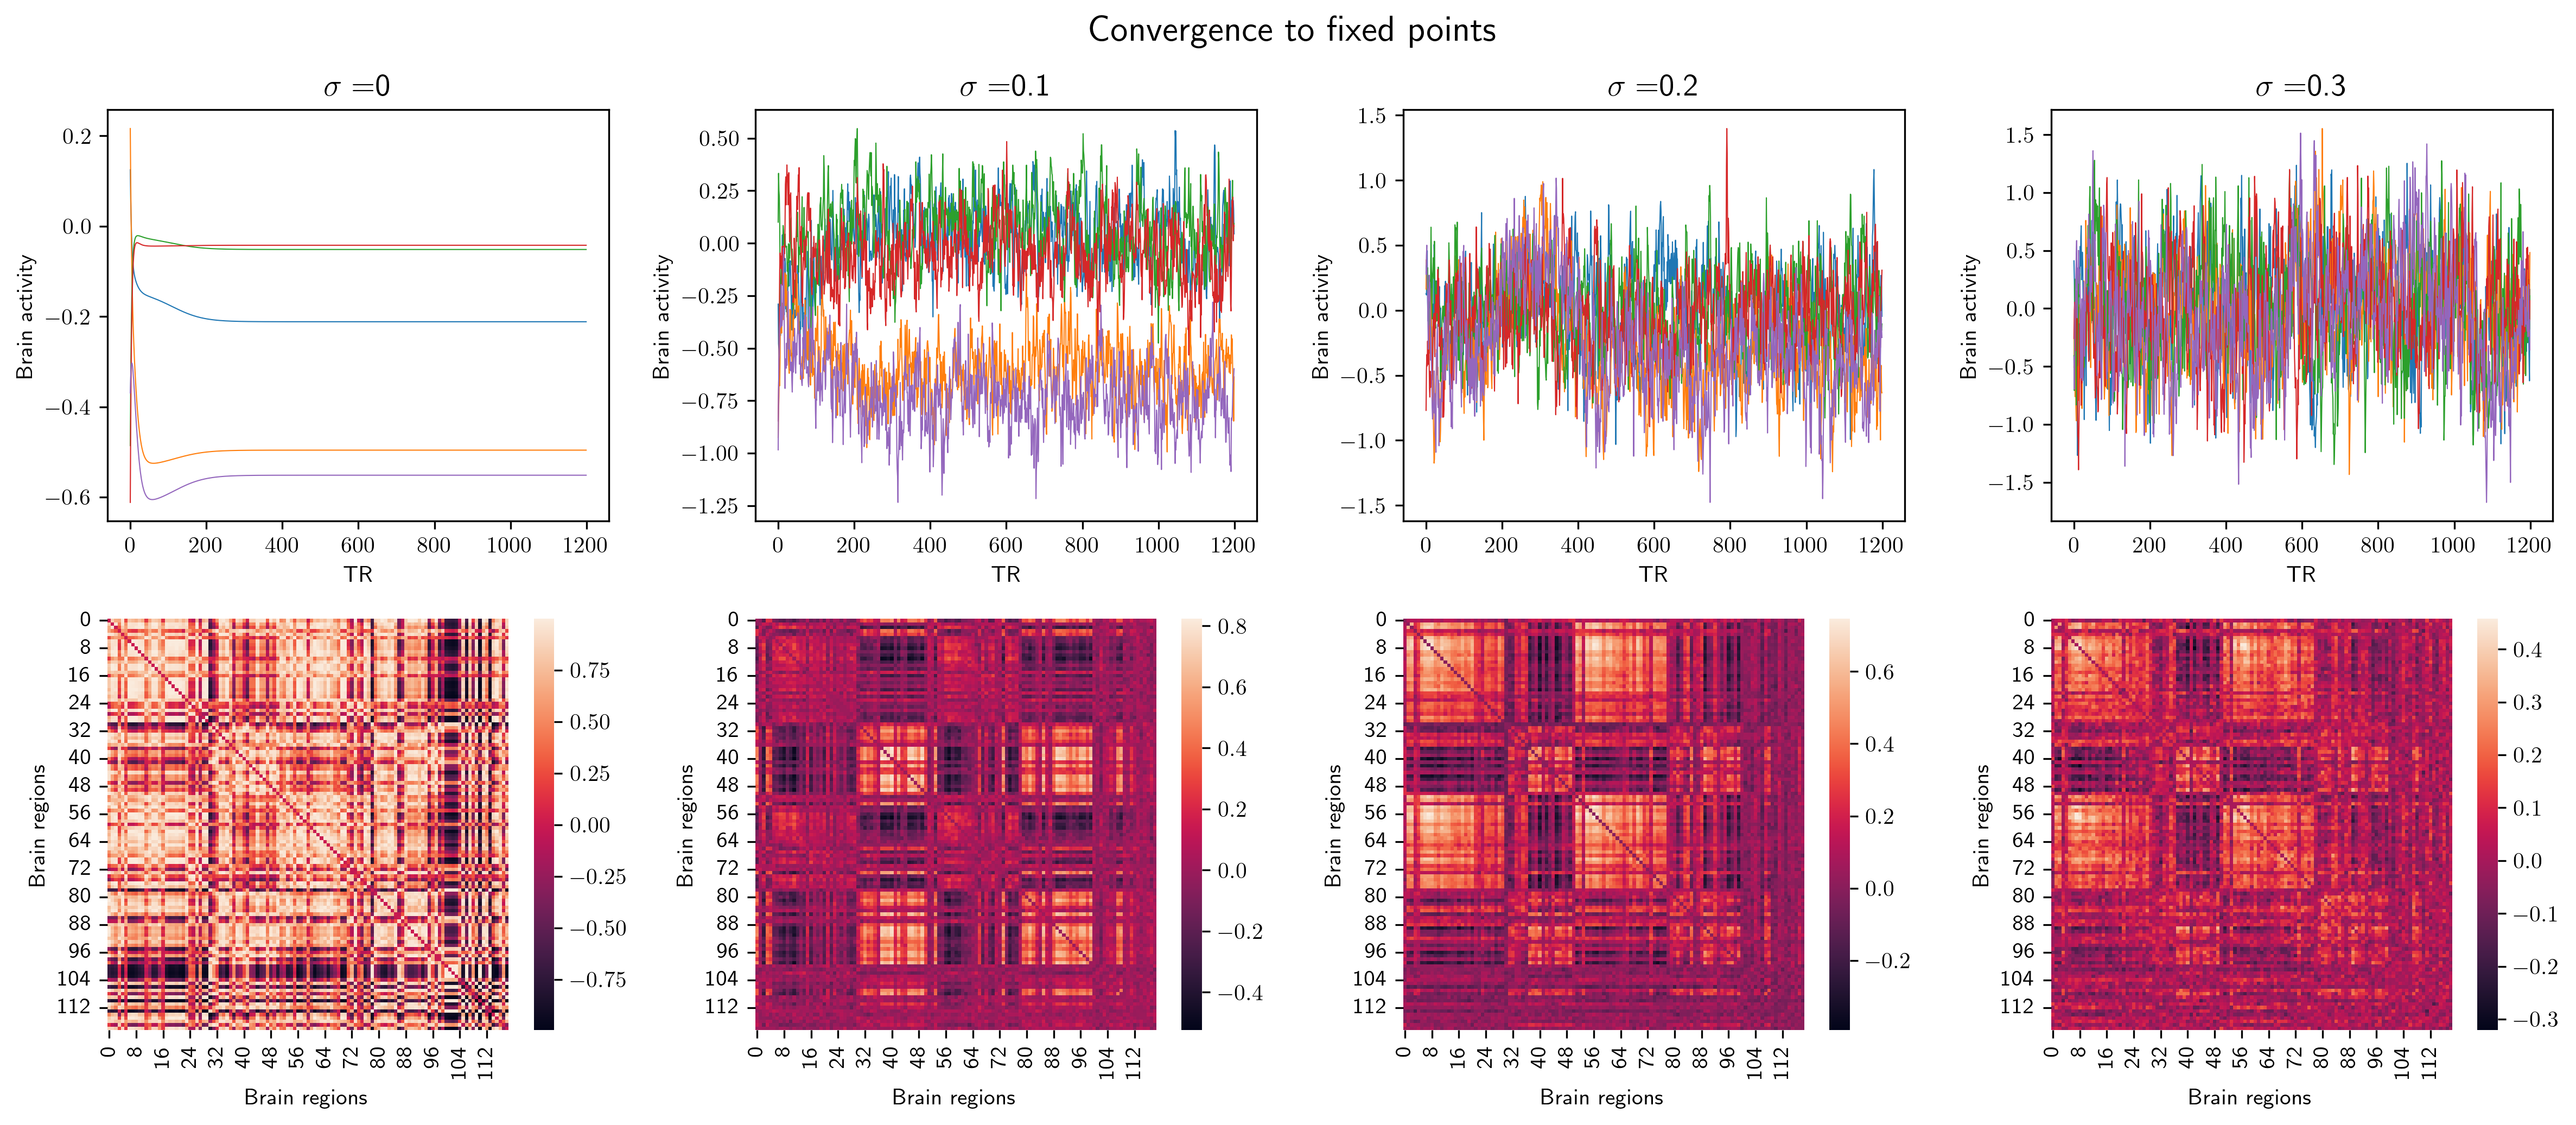

In [13]:
#Plot: simulation, FC, dFC
data, W, alpha, D = load_param(8)
sigma = [0, 0.1, 0.2, 0.3]

plt.figure(figsize=(16, 7), dpi=300)
plt.suptitle("Convergence to fixed points", fontsize=16)
for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.title("$\sigma = $" + str(sigma[i]), fontsize=14)
    plt.xlabel("TR")
    plt.ylabel("Brain activity")
    simul = propagation(W, alpha, D, sigma[i])
    plt.plot(np.arange(len(simul[0])), simul[0], lw=0.5)
    plt.plot(np.arange(len(simul[20])), simul[20], lw=0.5)
    plt.plot(np.arange(len(simul[30])), simul[30], lw=0.5)
    plt.plot(np.arange(len(simul[100])), simul[100], lw=0.5)
    plt.plot(np.arange(len(simul[60])), simul[60], lw=0.5)

    plt.subplot(2, 4, i+5)
    stream = dFC_stream(simul, 15)
    max_values = [0.8, 0.82, 0.65, 0.4]
    min_values = [-0.6, -0.65, -0.45, -0.2]
    #sn.heatmap(full_FC(simul), vmin=min_values[i], vmax=max_values[i])
    sn.heatmap(full_FC(simul)-np.diag(np.diag(full_FC(simul))))
    plt.xlabel("Brain regions")
    plt.ylabel("Brain regions")

plt.tight_layout()

In [7]:
def psi(x, alpha):
    b = 6.6667
    t1 = (alpha**2 + (b*x+0.5)**2)**0.5
    t2 = (alpha**2 + (b*x-0.5)**2)**0.5
    return t1 - t2

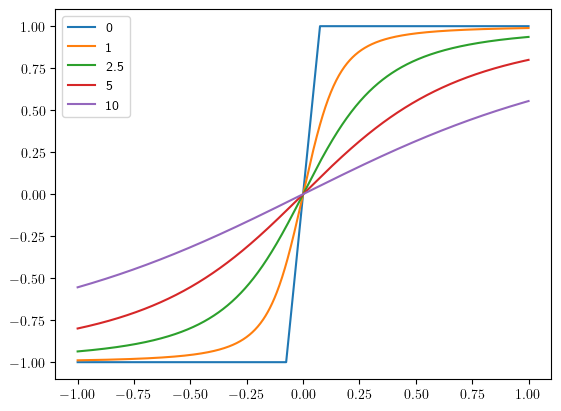

In [18]:
x = np.linspace(-1, 1, 1000)
alpha = [0, 1, 2.5, 5, 10]

for a in alpha:
    plt.plot(x, psi(x, a), label=str(a))
plt.legend()

In [8]:
%load_ext julia.magic

Initializing Julia interpreter. This may take some time...

In [12]:
%%julia
using Pkg
Pkg.add("LaTeXStrings")

    Updating registry at `C:\Users\paolo\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\paolo\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\paolo\.julia\environments\v1.8\Manifest.toml`


In [14]:
%julia Pkg.add("Plots")

   Resolving package versions...
  No Changes to `C:\Users\paolo\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\paolo\.julia\environments\v1.8\Manifest.toml`


In [34]:
%%julia
using Plots
using LaTeXStrings
p = plot(size=(1000, 700))
for a = $alpha
    plot!(p, $x, $psi($x, a), label=L"\alpha= " * string(a), linewidth=2)
end
plot!(p, xlabel="Node activation", ylabel="Node output", title=L"\psi_\alpha(x)", left_margin=5Plots.mm)
plot!(p, guidefontsize=20, legendfontsize=20, titlefontsize=30)
savefig(p, "./plots/psi.png")
display(p)


In [7]:
def propagation_prova(W, alpha, D, sigma):
    id_max = 10000
    Xt = np.zeros((119, id_max))
    x1 = np.random.random((119))*1.5 - 1       #x1 random
    Xt[:, 0] = x1

    Psi = np.zeros((119, id_max))

    TR = 0.1                #Small TR
    b = 6.6667
    for i in range(id_max-1):

        t1 = (alpha**2 + (b*x1+0.5)**2)**0.5
        t2 = (alpha**2 + (b*x1-0.5)**2)**0.5
        psi = t1 - t2

        eps = np.random.normal(0, sigma, x1.size)
        x2 = x1 + (np.dot(W, psi) - D*x1)*TR + eps

        Psi[:, i+1] = psi

        Xt[:, i+1] = x2
        x1 = x2


    dfXt = pd.DataFrame(Xt)
    simul = dfXt.T
    return simul

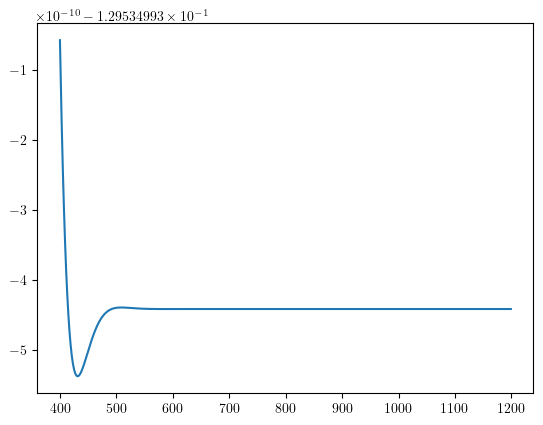

In [18]:
data, W, alpha, D = load_param(2)
#simul_prova = propagation_prova(W, alpha, D, 0)
simul = propagation(W, alpha, D, 0)

plt.plot(simul[10][400:])

###  Dynamics and stuff 

In [ ]:
def propagation_long(W, alpha, D, sigma):
    id_max = 12000
    Xt = np.zeros((119, id_max))
    x1 = np.random.random((119))*1.5 - 1       #x1 random
    Xt[:, 0] = x1

    Psi = np.zeros((119, id_max))

    TR = 0.7
    b = 6.6667
    for i in range(id_max-1):

        t1 = (alpha**2 + (b*x1+0.5)**2)**0.5
        t2 = (alpha**2 + (b*x1-0.5)**2)**0.5
        psi = t1 - t2

        eps = np.random.normal(0, sigma, x1.size)
        x2 = x1 + (np.dot(W, psi) - D*x1)*TR + eps

        Psi[:, i+1] = psi

        Xt[:, i+1] = x2
        x1 = x2


    dfXt = pd.DataFrame(Xt)
    simul = dfXt.T
    return simul

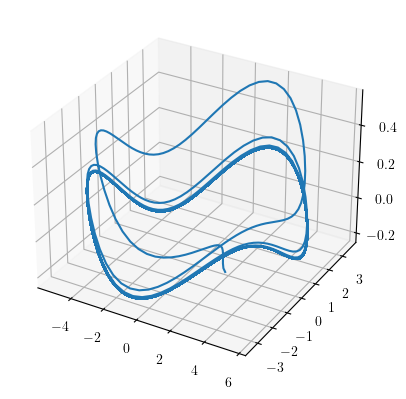

In [ ]:
data, W, alpha, D = load_param(1)
simul = propagation_long(W, alpha, D, 0)
simul_values = simul.values

from sklearn.decomposition import PCA
num_components = 3
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(simul_values)

#np.save("pca1.npy", principal_components)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2])


In [ ]:
#Jacobian of psi function
def d_psi(alpha, b, x):
    tp = b*x+0.5
    tn = b*x-0.5
    return b*tp/(alpha**2+tp**2)**0.5 - b*tn/(alpha**2+tn**2)**0.5

In [ ]:
data, W, alpha, D = load_param(2)

J_psi = np.identity(119)*d_psi(alpha, b, 0)
A_tilde = np.dot(W, J_psi) - np.identity(119)*D

In [ ]:
x_t = np.zeros((119, 30))
x_t[:, 0] = np.random.random(119)

for i in range(29):
    x_t[:, i+1] = np.dot(A_tilde, x_t[:, i]) + np.random.normal(0, 0.3, 119)

### Parameters

In [49]:
#Alpha
alpha_cycle = []
alpha_fixed = []

for i in range(96):
    subject, W, alpha, D = load_param(i)
    if classification[i] == 0:
        alpha_cycle.append(alpha)
    else:
        alpha_fixed.append(alpha)

(array([ 2.,  5., 10., 17., 19., 27., 12., 14.,  4.,  9.]),
 array([4.94475363, 4.96786769, 4.99098174, 5.0140958 , 5.03720986,
        5.06032391, 5.08343797, 5.10655202, 5.12966608, 5.15278014,
        5.17589419]),
 <BarContainer object of 10 artists>)

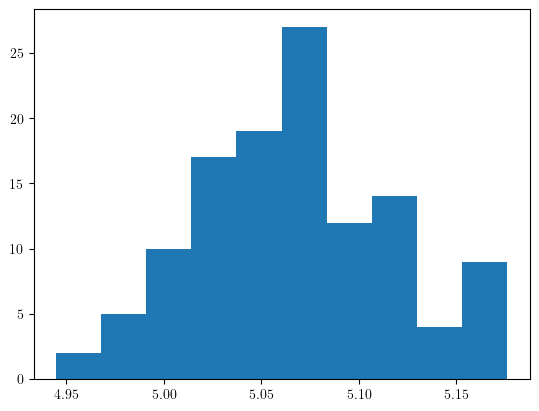

In [51]:
plt.hist(alpha_fixed[10])

In [ ]:
#Subselection
alpha_fixed = alpha_fixed[:16]
len(alpha_cycle)-len(alpha_fixed)

0

In [ ]:
ks_alpha_cycle = []
ks_alpha_fixed = []
ks_alpha_mixed = []

for i in range(len(alpha_cycle)):
    for j in range(len(alpha_cycle)):
        if i<j:
            ks_alpha_cycle.append(kstest(alpha_cycle[i], alpha_cycle[j])[0])

for i in range(len(alpha_fixed)):
    for j in range(len(alpha_fixed)):
        if i<j:
            ks_alpha_fixed.append(kstest(alpha_fixed[i], alpha_fixed[j])[0])


for i in range(len(alpha_cycle)):
    for j in range(len(alpha_fixed)):
        ks_alpha_mixed.append(kstest(alpha_cycle[i], alpha_fixed[j])[0])

{'whiskers': [<matplotlib.lines.Line2D at 0x1e7fd1e7810>,
 'caps': [<matplotlib.lines.Line2D at 0x1e7fd1e6410>,
 'boxes': [<matplotlib.lines.Line2D at 0x1e7fd212050>],
 'medians': [<matplotlib.lines.Line2D at 0x1e7fd1e50d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e7fd1e6550>],
 'means': []}

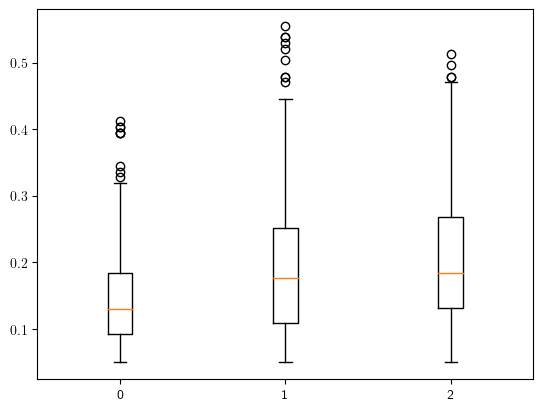

In [ ]:
plt.figure()
plt.boxplot(ks_alpha_cycle, positions=[0])
plt.boxplot(ks_alpha_mixed, positions=[1])
plt.boxplot(ks_alpha_fixed, positions=[2])

In [ ]:
#D
D_cycle = []
D_fixed = []

for i in range(96):
    subject, W, alpha, D = load_param(i)
    if classification[i] == 0:
        D_cycle.append(D)
    else:
        D_fixed.append(D)

In [ ]:
#Subselection
D_fixed = D_fixed[:16]
len(D_cycle)-len(D_fixed)

0

In [ ]:
ks_D_cycle = []
ks_D_fixed = []
ks_D_mixed = []

for i in range(len(D_cycle)):
    for j in range(len(D_cycle)):
        if i<j:
            ks_D_cycle.append(kstest(D_cycle[i], D_cycle[j])[0])

for i in range(len(D_fixed)):
    for j in range(len(D_fixed)):
        if i<j:
            ks_D_fixed.append(kstest(D_fixed[i], D_fixed[j])[0])

for i in range(len(D_cycle)):
    for j in range(len(D_fixed)):
        ks_D_mixed.append(kstest(D_cycle[i], D_fixed[j])[0])

{'whiskers': [<matplotlib.lines.Line2D at 0x2449c189cd0>,
 'caps': [<matplotlib.lines.Line2D at 0x2449c18b6d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2449c176850>],
 'medians': [<matplotlib.lines.Line2D at 0x2449c198d10>],
 'fliers': [<matplotlib.lines.Line2D at 0x2449c199810>],
 'means': []}

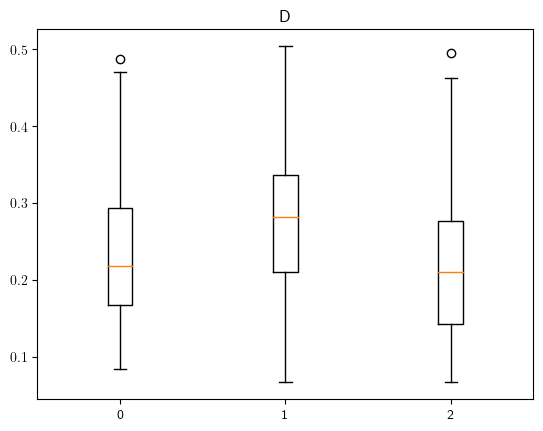

In [ ]:
plt.figure()
plt.title("D")
plt.boxplot(ks_D_cycle, positions=[0])
plt.boxplot(ks_D_mixed, positions=[1])
plt.boxplot(ks_D_fixed, positions=[2])

In [ ]:
#W
W_cycle = []
W_fixed = []

for i in range(96):
    subject, W, alpha, D = load_param(i)
    if classification[i] == 0:
        W_cycle.append(W)
    else:
        W_fixed.append(W)

In [ ]:
#Subselection
W_fixed = W_fixed[:16]
len(W_cycle)-len(W_fixed)

0

In [ ]:
d_W_cycle = []
d_W_fixed = []
d_W_mixed = []

for i in range(len(W_cycle)):
    for j in range(len(W_cycle)):
        if i<j:
            Vec_i = W_cycle[i].flatten()
            Vec_j = W_cycle[j].flatten()
            
            d_W_cycle.append(1-np.corrcoef(Vec_i, Vec_j)[0, 1])

for i in range(len(W_fixed)):
    for j in range(len(W_fixed)):
        if i<j:
            Vec_i = W_fixed[i].flatten()
            Vec_j = W_fixed[j].flatten()
            
            d_W_fixed.append(1-np.corrcoef(Vec_i, Vec_j)[0, 1])


for i in range(len(W_cycle)):
    for j in range(len(W_fixed)):
        Vec_i = W_cycle[i].flatten()
        Vec_j = W_fixed[j].flatten()

        d_W_mixed.append(1-np.corrcoef(Vec_i, Vec_j)[0, 1])

{'whiskers': [<matplotlib.lines.Line2D at 0x244a420bb90>,
 'caps': [<matplotlib.lines.Line2D at 0x244a4211010>,
 'boxes': [<matplotlib.lines.Line2D at 0x244a41bb410>],
 'medians': [<matplotlib.lines.Line2D at 0x244a42121d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x244a4212950>],
 'means': []}

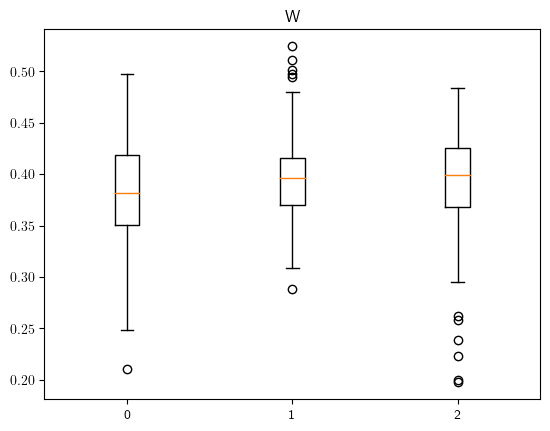

In [ ]:
plt.figure()
plt.title("W")
plt.boxplot(d_W_cycle, positions=[0])
plt.boxplot(d_W_mixed, positions=[1])
plt.boxplot(d_W_fixed, positions=[2])

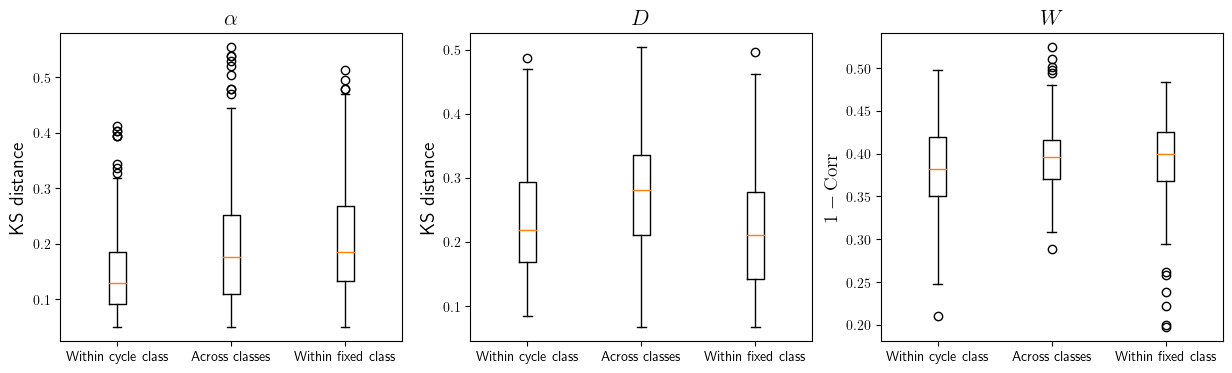

In [ ]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title(r"$\alpha$", fontsize=16)
plt.boxplot(ks_alpha_cycle, positions=[0])
plt.boxplot(ks_alpha_mixed, positions=[1])
plt.boxplot(ks_alpha_fixed, positions=[2])
plt.ylabel("KS distance", fontsize=14)
plt.xticks([0, 1, 2], ['Within cycle class', 'Across classes', 'Within fixed class'])

plt.subplot(132)
plt.title(r"$D$", fontsize=16)
plt.boxplot(ks_D_cycle, positions=[0])
plt.boxplot(ks_D_mixed, positions=[1])
plt.boxplot(ks_D_fixed, positions=[2])
plt.ylabel("KS distance", fontsize=14)
plt.xticks([0, 1, 2], ['Within cycle class', 'Across classes', 'Within fixed class'])

plt.subplot(133)
plt.title(r"$W$", fontsize=16)
plt.boxplot(d_W_cycle, positions=[0])
plt.boxplot(d_W_mixed, positions=[1])
plt.boxplot(d_W_fixed, positions=[2])
plt.ylabel(r"$1-\mathrm{Corr}$", fontsize=14)
plt.xticks([0, 1, 2], ['Within cycle class', 'Across classes', 'Within fixed class'])

plt.savefig("parameters_dist.png")

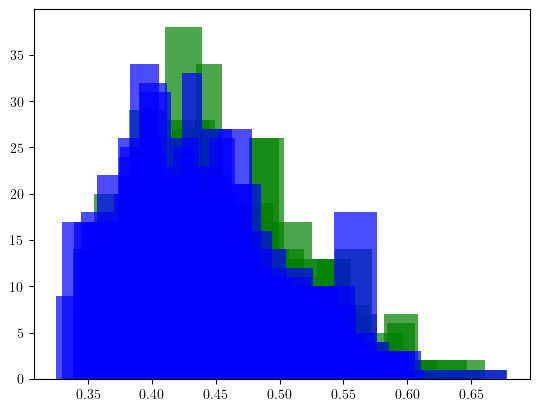

In [ ]:
for i in range(len(D_cycle)):
    plt.hist(D_cycle[i], color="green", alpha=0.7)
for i in range(len(D_fixed)):
    plt.hist(D_fixed[i], color="blue", alpha=0.7)

### Sigma

In [ ]:
sigma = np.linspace(0, 0.7, 20)
table = np.zeros((len(sigma), 96))

for j in range(len(sigma)):
    print(j)
    for i in range(96):
        subject, W, alpha, D = load_param(i)
        subject = subject.apply(zscore)
        FC_exp = full_FC(subject)
        UpperTri_exp = FC_exp[np.triu_indices(FC_exp.shape[1], k=1)]

        simul = propagation(W, alpha, D, sigma[j])
        FC_simul = full_FC(simul)
        UpperTri_simul = FC_simul[np.triu_indices(FC_simul.shape[1], k=1)]
        
        rho = np.corrcoef(UpperTri_exp, UpperTri_simul)[0, 1]

        table[j, i] = rho

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [ ]:
#np.save("table_sigma", table)

In [ ]:
median_cycle = []
median_fixed = []

for j in range(len(sigma)):
    cycle = []
    fixed = []
    for i in range(96):
        if classification[i] == 0:
            cycle.append(table[j, i])
        else:
            fixed.append(table[j, i])
    median_cycle.append(np.median(np.array(cycle)))
    median_fixed.append(np.median(np.array(fixed)))

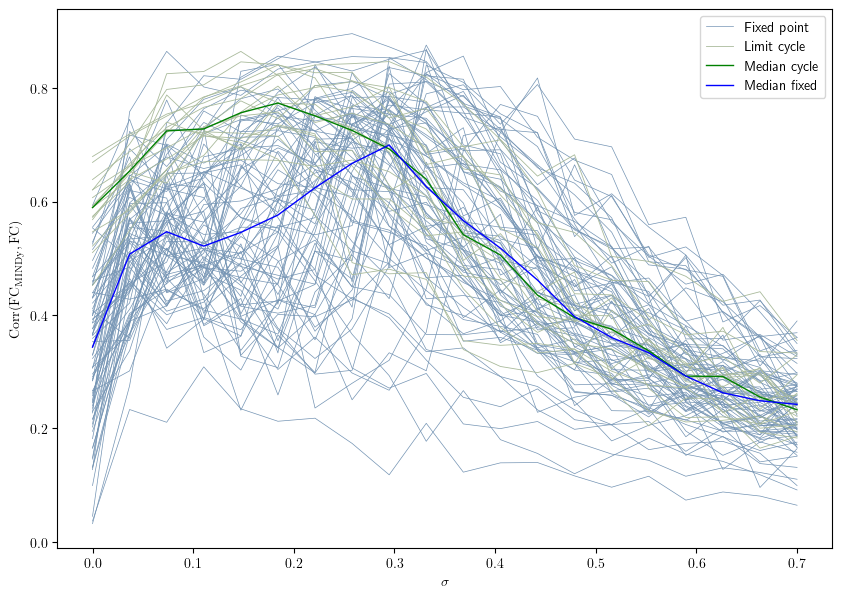

In [ ]:
plt.figure(figsize=(10, 7))
plt.xlabel(r"$\sigma$")
plt.ylabel(r"$\mathrm{Corr}(\mathrm{FC}_{\mathrm{MINDy}}, \mathrm{FC})$")

legend_fixed = False
legend_cycle = False

line = 0.5
alpha = 1
for i in range(96):
    if classification[i] == 1:
        if legend_fixed == False:
            plt.plot(sigma, table[:, i], lw=line, color="#7393B3", alpha=alpha, label="Fixed point")
            legend_fixed = True
        else:
            plt.plot(sigma, table[:, i], lw=line, color="#7393B3", alpha=alpha)
for i in range(96):
    if classification[i] == 0:
        if legend_cycle == False:
            plt.plot(sigma, table[:, i], lw=1.2*line, color="#A9BA9B", alpha=alpha, label="Limit cycle")
            legend_cycle = True
        else:
            plt.plot(sigma, table[:, i], lw=1.2*line, color="#A9BA9B", alpha=alpha)

plt.plot(sigma, median_cycle, color="green", lw=1, label="Median cycle")
plt.plot(sigma, median_fixed, color="blue", lw=1, label="Median fixed")
plt.legend()

In [15]:
cycle02 = []
fixed02 = []



for i in range(96):
    subject, W, alpha, D = load_param(i)
    subject = subject.apply(zscore)
    FC_exp = full_FC(subject)
    UpperTri_exp = FC_exp[np.triu_indices(FC_exp.shape[1], k=1)]

    simul = propagation(W, alpha, D, 0.2)
    FC_simul = full_FC(simul)
    UpperTri_simul = FC_simul[np.triu_indices(FC_simul.shape[1], k=1)]
    
    rho = np.corrcoef(UpperTri_exp, UpperTri_simul)[0, 1]   

    if classification[i] == 0:
        cycle02.append(rho)
    else:
        fixed02.append(rho)

{'bodies': [<matplotlib.collections.PolyCollection at 0x2a1b04291d0>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x2a1b0452150>,
 'cmins': <matplotlib.collections.LineCollection at 0x2a1b0458810>,
 'cbars': <matplotlib.collections.LineCollection at 0x2a1b03c8550>}

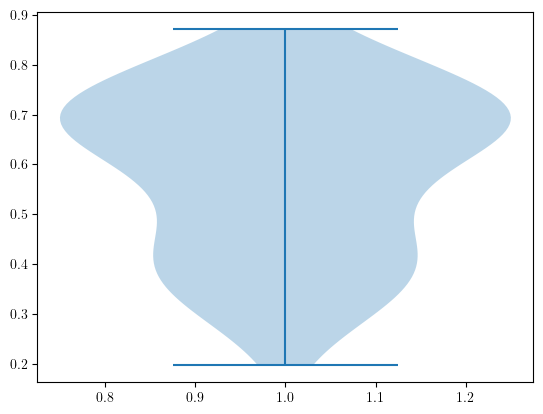

In [ ]:
plt.violinplot(fixed02)

Text(0.5, 1.0, '$\\sigma=0.2$')

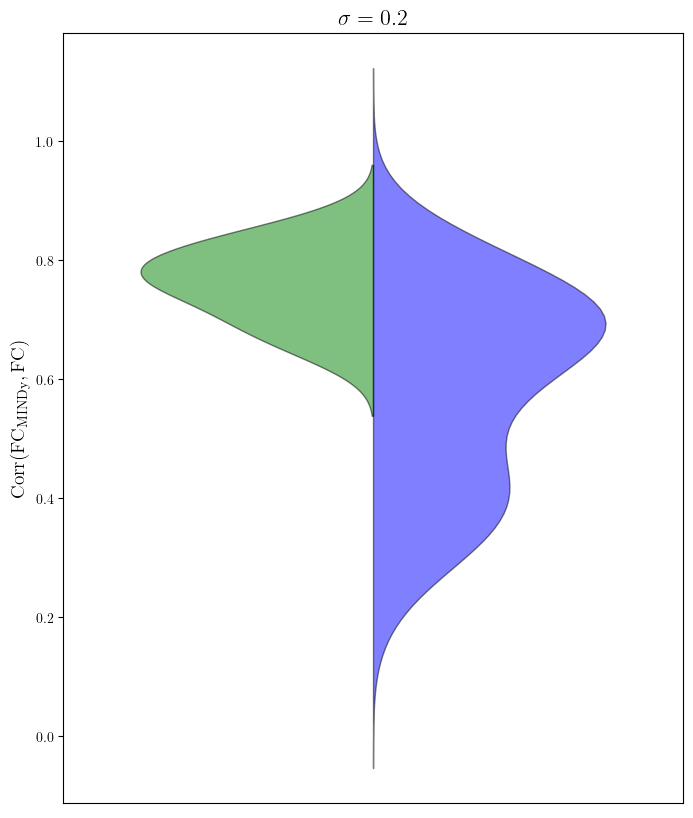

In [ ]:
from statsmodels.graphics.boxplots import violinplot
fig, ax = plt.subplots(figsize=(8, 10))
violin_cycle = violinplot([cycle02], positions=[0], show_boxplot=False, side='left', ax=ax, plot_opts={'violin_fc':'C0', 'violin_fc' : 'green', 'label' : 'Cycle limit' })
violin_fixed = violinplot([fixed02], positions=[0], show_boxplot=False, side='right', ax=ax, plot_opts={'violin_fc':'C1', 'violin_fc' : 'blue', 'label' : 'Fixed point'})
ax.set_xticks([])
ax.set_xlim(-0.2, 0.2)
ax.set_ylabel(r"$\mathrm{Corr}(\mathrm{FC}_{\mathrm{MINDy}}, \mathrm{FC})$", fontsize=14)
ax.set_title(r"$\sigma=0.2$", fontsize=16)


### Back to propagation

In [ ]:
from scipy.special import gamma

def hrf_function(t, alpha1, alpha2, beta1, beta2, c):
    term1 = (t ** (alpha1 - 1) * np.exp(-beta1 * t) * beta1 ** alpha1) / gamma(alpha1)
    term2 = (t ** alpha2 * np.exp(-beta2 * t) * beta2 ** alpha2) / (c * gamma(alpha2))
    return term1 - term2
alpha1 = 6
alpha2 = 16
beta1 = 1
beta2 = 1
c = 1/6

In [ ]:
def propagation(W, alpha, D, sigma):
    id_max = 1200
    Xt = np.zeros((119, id_max))
    x1 = np.random.random((119))*1.5 - 1       #x1 random
    Xt[:, 0] = x1

    Psi = np.zeros((119, id_max))

    #TR = 0.7/4
    TR = 0.7
    b = 6.6667
    for i in range(id_max-1):

        t1 = (alpha**2 + (b*x1+0.5)**2)**0.5
        t2 = (alpha**2 + (b*x1-0.5)**2)**0.5
        psi = t1 - t2

        eps = np.random.normal(0, sigma, x1.size)
        x2 = x1 + (np.dot(W, psi) - D*x1)*TR + eps

        Psi[:, i+1] = psi

        Xt[:, i+1] = x2
        x1 = x2


    dfXt = pd.DataFrame(Xt)
    simul = dfXt.T
    return simul

In [ ]:
from scipy.signal import resample
def simul_resampled(simul):
    d = len(resample(simul[0], int(len(simul[0]) * 1/4)))
    simul_r = np.zeros((d, 119))
    for i in range(119):
        simul_r[:, i] =  resample(simul[i], int(len(simul[i]) * 1/4))
    simul_r = pd.DataFrame(simul_r)
    return simul_r

In [ ]:
def simul_plus(simul):
    simul_plus = np.zeros(simul.shape)
    for i in range(119):
        simul_plus[:, i] = np.convolve(simul[i], hrf, mode='full')[:len(simul)]
    simul_plus = pd.DataFrame(simul_plus)
    return simul_plus

In [ ]:
t = np.arange(0, 50, 0.7)
hrf = hrf_function(t, alpha1, alpha2, beta1, beta2, c)

data, W, alpha, D = load_param(70)
simul = propagation(W, alpha, D, 0.45)
simul = simul_resampled(simul)

In [ ]:
simul_p = simul_plus(simul)

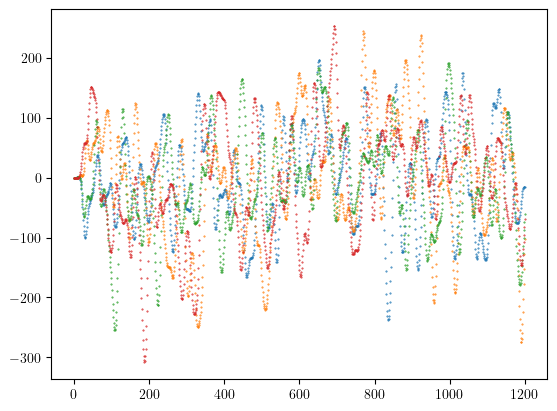

In [ ]:
x = np.arange(len(simul_p[0]))
plt.scatter(x, simul_p[0], s=0.2)
plt.scatter(x, simul_p[2], s=0.2)
plt.scatter(x, simul_p[10], s=0.2)
plt.scatter(x, simul_p[42], s=0.2)

In [ ]:
vz_short = pooled_v_stream(simul_p, 8, 20)
vz_mid = pooled_v_stream(simul_p, 21, 82)
vz_long = pooled_v_stream(simul_p, 83, 290)

(0.0, 1.1)

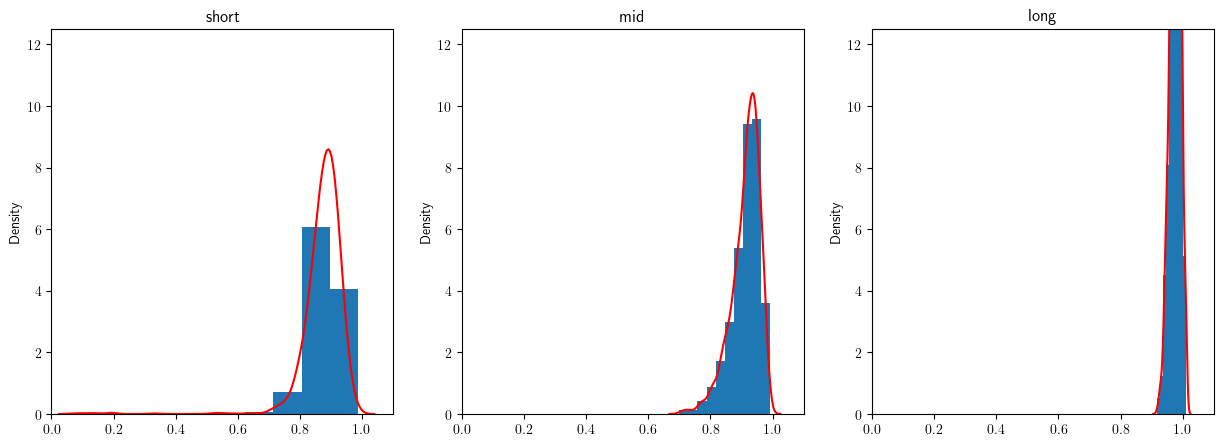

In [ ]:
#V distribution
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("short")
plt.hist(vz_short, density=True)
sn.kdeplot(vz_short, color="red")
plt.ylim((0, 12.5))
plt.xlim((0, 1.1))

plt.subplot(132)
plt.title("mid")
plt.hist(vz_mid, density=True)
sn.kdeplot(vz_mid, color="red")
plt.ylim((0, 12.5))
plt.xlim((0, 1.1))

plt.subplot(133)
plt.title("long")
plt.hist(vz_long, density=True)
sn.kdeplot(vz_long, color="red")
plt.ylim((0, 12.5))
plt.xlim((0, 1.1))

In [ ]:
vz_short = pooled_v_stream(simul, 8, 20)
vz_mid = pooled_v_stream(simul, 21, 82)
vz_long = pooled_v_stream(simul, 83, 290)

(0.0, 1.1)

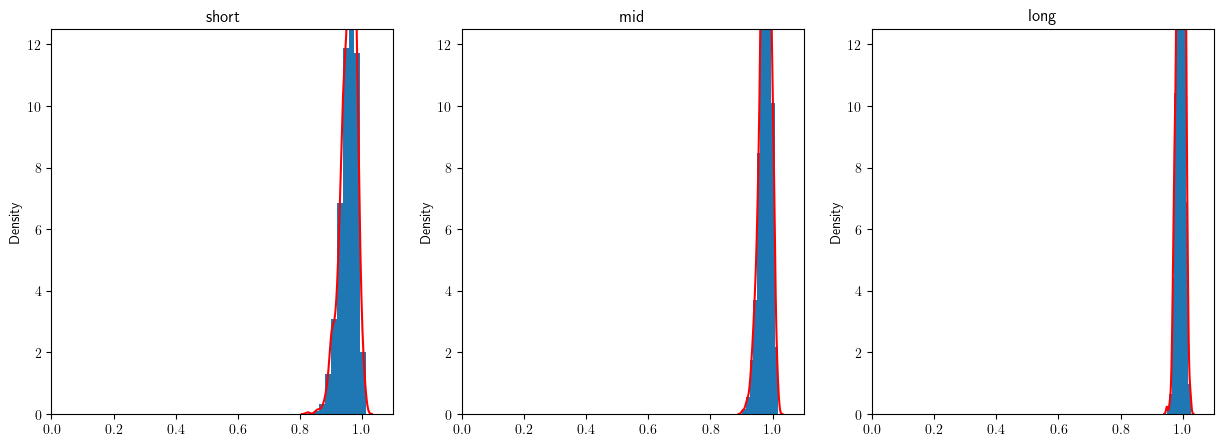

In [ ]:
#V distribution
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("short")
plt.hist(vz_short, density=True)
sn.kdeplot(vz_short, color="red")
plt.ylim((0, 12.5))
plt.xlim((0, 1.1))

plt.subplot(132)
plt.title("mid")
plt.hist(vz_mid, density=True)
sn.kdeplot(vz_mid, color="red")
plt.ylim((0, 12.5))
plt.xlim((0, 1.1))

plt.subplot(133)
plt.title("long")
plt.hist(vz_long, density=True)
sn.kdeplot(vz_long, color="red")
plt.ylim((0, 12.5))
plt.xlim((0, 1.1))

### Ouch

In [19]:
#Classification: limit cycle (0) vs fixed point (1)
classification = []
for idx in range(len(datasets)):
    #Get parameters
    data, W, alpha, D = load_param(idx)
    simul = propagation(W, alpha, D, 0)
    
    #Classification
    std = np.std(simul[-10:])
    m = std.mean()
    c = 1e-6

    if m<c: 
        classification.append(1)
    else:
        classification.append(0)

In [ ]:
#np.save("classification.npy", classification)

In [ ]:
s_range = []

for i in range(96):
    data, W, alpha, D = load_param(i)
    subject = propagation(W, alpha, D, 0.2)

    v_subject = pooled_v_stream(subject, 8, 20)
    s_range.append(v_subject)

In [ ]:
m_range = []

for i in range(len(datasets)):
    data, W, alpha, D = load_param(i)
    subject = propagation(W, alpha, D, 0.2)

    v_subject = pooled_v_stream(subject, 21, 82)
    m_range.append(v_subject)

In [ ]:
l_range = []

for i in range(len(datasets)):
    data, W, alpha, D = load_param(i)
    subject = propagation(W, alpha, D, 0.2)

    v_subject = pooled_v_stream(subject, 83, 290)
    l_range.append(v_subject)

In [ ]:
short_range_list = []
mid_range_list = []
long_range_list = []

for subject in datasets:
    v_subject = pooled_v_stream(subject, 3, 8)
    short_range_list.append(v_subject)

    v_subject = pooled_v_stream(subject, 21, 82)
    mid_range_list.append(v_subject)

    v_subject = pooled_v_stream(subject, 83, 290)
    long_range_list.append(v_subject)

In [ ]:
df = pd.DataFrame({"class" : classification, "eigenvalue" : max_eigenvalue, 
                    "short_mindy" : s_range, "mid_mindy" : m_range, "long_mindy" : l_range,
                    "short" : short_range_list, "mid" : mid_range_list, "long" : long_range_list})

In [ ]:
short_range_fixed_list = df[df["class"] == 1]["short_mindy"]
short_range_cycle_list = df[df["class"] == 0]["short_mindy"]
mid_range_fixed_list = df[df["class"] == 1]["mid_mindy"]
mid_range_cycle_list = df[df["class"] == 0]["mid_mindy"]
long_range_fixed_list = df[df["class"] == 1]["long_mindy"]
long_range_cycle_list = df[df["class"] == 0]["long_mindy"]

In [ ]:
short_range_fixed = np.array([])
short_range_cycle = np.array([])
mid_range_fixed = np.array([])
mid_range_cycle = np.array([])
long_range_fixed = np.array([])
long_range_cycle = np.array([])


for e in short_range_fixed_list:
    short_range_fixed = np.concatenate((short_range_fixed, e))

for e in short_range_cycle_list:
    short_range_cycle = np.concatenate((short_range_cycle, e))

for e in mid_range_fixed_list:
    mid_range_fixed = np.concatenate((mid_range_fixed, e))

for e in mid_range_cycle_list:
    mid_range_cycle = np.concatenate((mid_range_cycle, e))

for e in long_range_fixed_list:
    long_range_fixed = np.concatenate((long_range_fixed, e))

for e in long_range_cycle_list:
    long_range_cycle = np.concatenate((long_range_cycle, e))



In [ ]:
short_range = np.array([])
mid_range = np.array([])
long_range = np.array([])

for e in df["short"]:
    short_range = np.concatenate((short_range, e))

for e in df["mid"]:
    mid_range = np.concatenate((mid_range, e))
    
for e in df["long"]:
    long_range = np.concatenate((long_range, e))

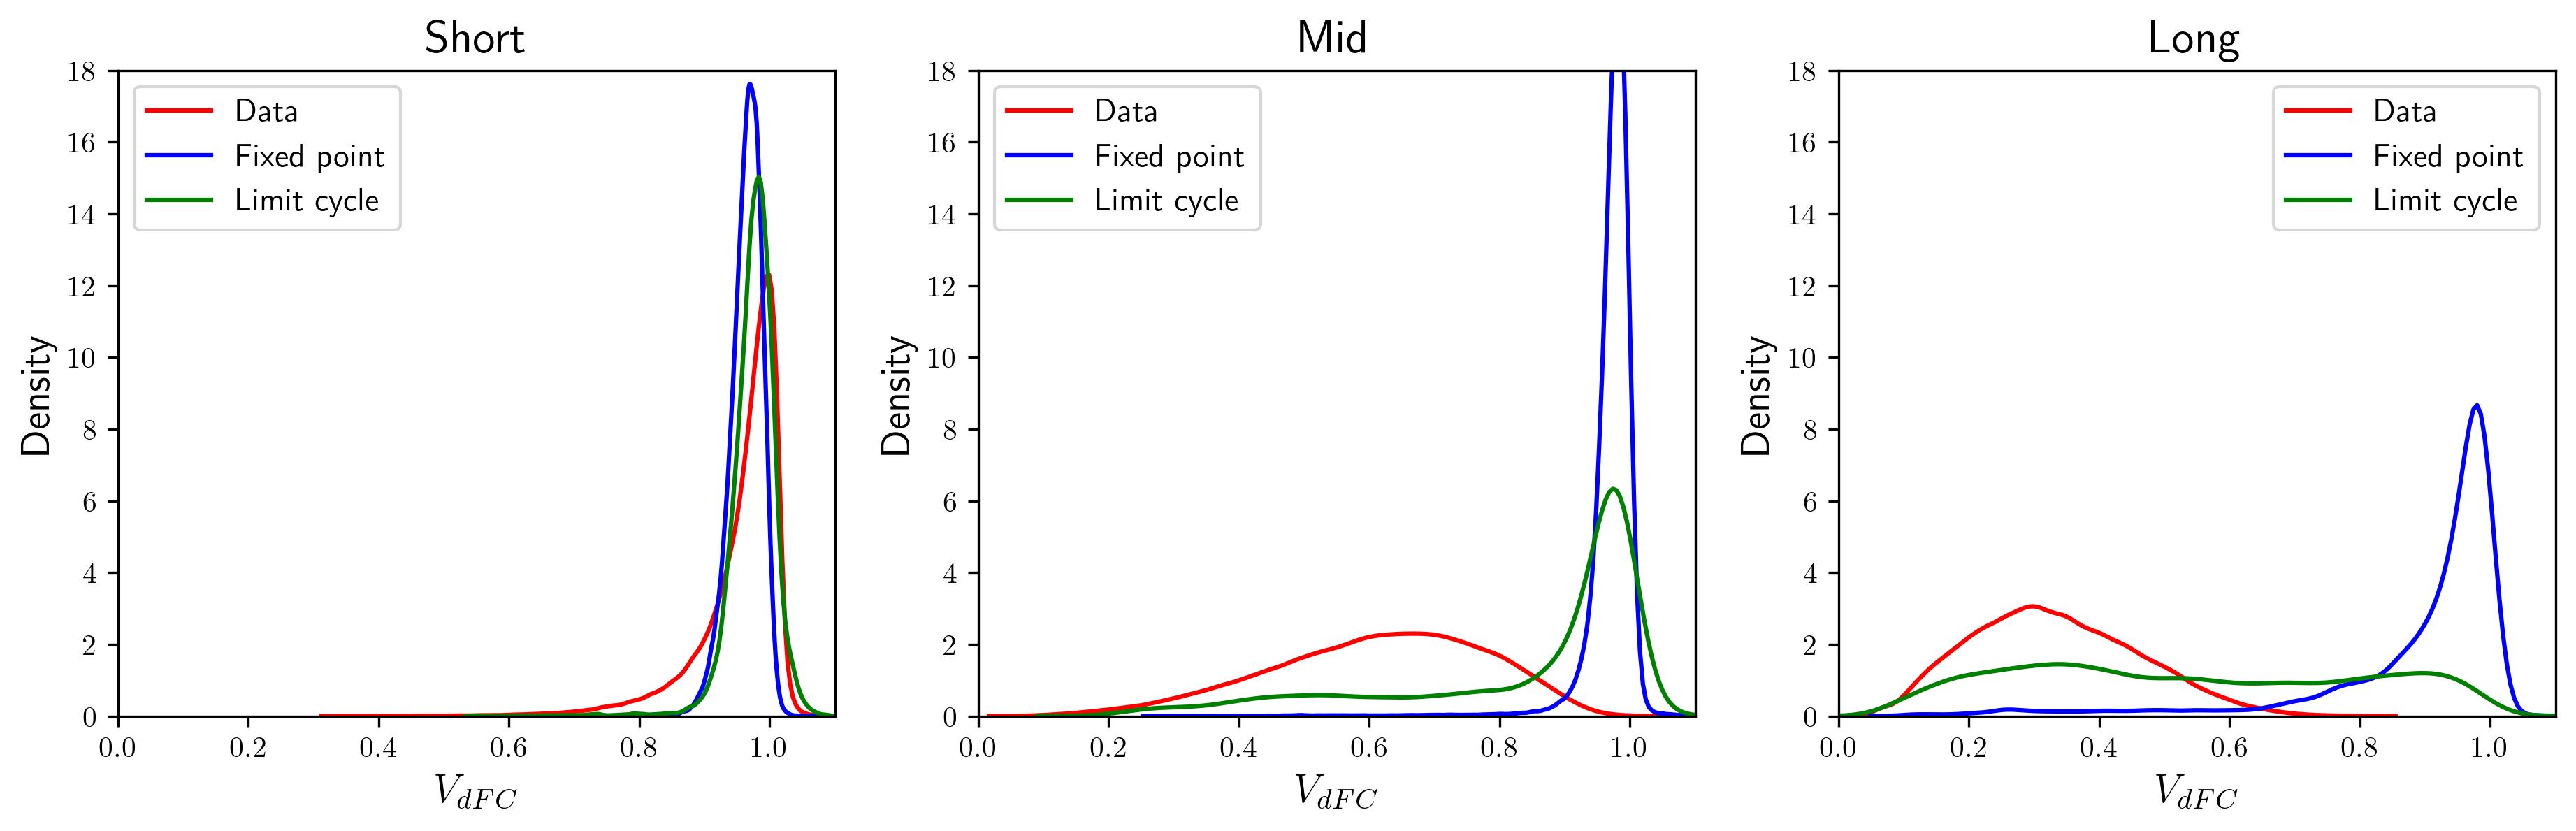

In [ ]:
plt.figure(figsize=(15, 4), dpi=300)
plt.subplot(131)
plt.title("Short", fontsize=16)
plt.xlabel(r"$V_{dFC}$", fontsize=14)
plt.ylabel("Density", fontsize=14)
sn.kdeplot(short_range, color="red", label="Data")
sn.kdeplot(short_range_fixed, color="blue", label="Fixed point")
sn.kdeplot(short_range_cycle, color="green", label="Limit cycle")
plt.legend(fontsize=11)
plt.ylim((0, 18))
plt.xlim((0, 1.1))

plt.subplot(132)
plt.title("Mid", fontsize=16)
plt.xlabel(r"$V_{dFC}$", fontsize=14)
plt.ylabel("Density", fontsize=14)
sn.kdeplot(mid_range, color="red", label="Data")
sn.kdeplot(mid_range_fixed, color="blue", label="Fixed point")
sn.kdeplot(mid_range_cycle, color="green", label="Limit cycle")
plt.legend(fontsize=11)
plt.ylim((0, 18))
plt.xlim((0, 1.1))

plt.subplot(133)
plt.title("Long", fontsize=16)
plt.xlabel(r"$V_{dFC}$", fontsize=14)
plt.ylabel("Density", fontsize=14)
sn.kdeplot(long_range, color="red", label="Data")
sn.kdeplot(long_range_fixed, color="blue", label="Fixed point")
sn.kdeplot(long_range_cycle, color="green", label="Limit cycle")
plt.legend(fontsize=11)
plt.ylim((0, 18))
plt.xlim((0, 1.1))

#plt.savefig("./plots/v_dist_mindy.png")

In [ ]:
#Jacobian of psi function
def d_psi(alpha, b, x):
    tp = b*x+0.5
    tn = b*x-0.5
    return b*tp/(alpha**2+tp**2)**0.5 - b*tn/(alpha**2+tn**2)**0.5

In [ ]:
max_eigenvalue = []

for i in range(96):
    data, W, alpha, D = load_param(i)
    simul = propagation(W, alpha, D, 0)

    if classification[i] == 0:
        #Jacobian
        J_psi = np.diag(d_psi(alpha, b, 0))
        A_tilde = np.dot(W, J_psi) - np.identity(119)*D
        #A_tilde = np.dot(W, J_psi)
        eigen = np.linalg.eig(A_tilde)[0]

        max_eigenvalue.append(max(eigen.real))

    if classification[i] == 1:
        #Jacobian
        x_tilde = simul[-10:].mean()
        J_psi = np.diag(d_psi(alpha, b, x_tilde))
        A_tilde = np.dot(W, J_psi) - np.identity(119)*D
        #A_tilde = np.dot(W, J_psi)
        eigen = np.linalg.eig(A_tilde)[0]

        max_eigenvalue.append(max(eigen.real))

In [ ]:
def get_mode(distribution, num_bins):
    hist, bin_edges = np.histogram(distribution, bins=num_bins)
    bin_index = np.argmax(hist)
    mode = (bin_edges[bin_index] + bin_edges[bin_index+1])/2
    return mode

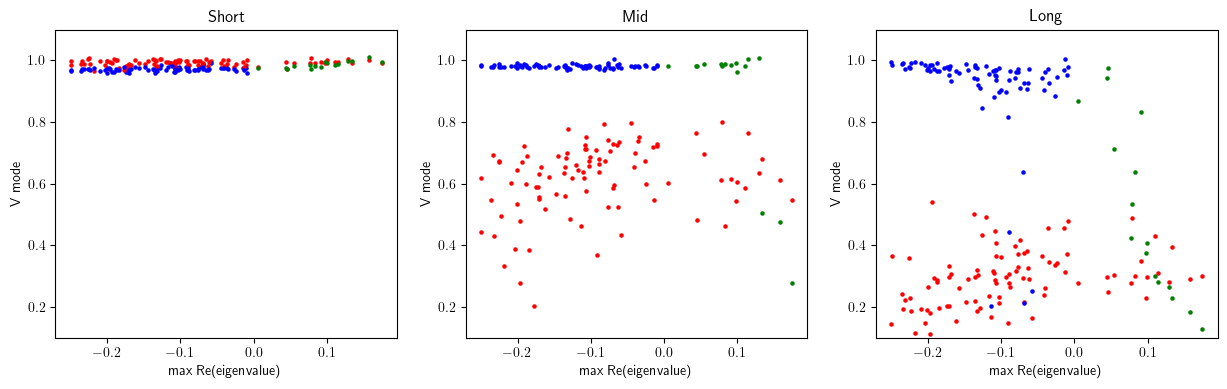

In [ ]:
bin = 20

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title("Short")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("V mode")
plt.ylim(0.1, 1.1)
for i in range(96):
    plt.scatter(max_eigenvalue[i], get_mode(short_range_list[i], bin), c="red", s=5)
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], get_mode(short_range_cycle_list[i], bin), c="green", s=5)
    else:
        plt.scatter(max_eigenvalue[i], get_mode(short_range_fixed_list[i], bin), c="blue", s=5)
    
plt.subplot(132)
plt.title("Mid")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("V mode")
plt.ylim(0.1, 1.1)
for i in range(96):
    plt.scatter(max_eigenvalue[i], get_mode(mid_range_list[i], bin), c="red", s=5)
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], get_mode(mid_range_cycle_list[i], bin), c="green", s=5)
    else:
        plt.scatter(max_eigenvalue[i], get_mode(mid_range_fixed_list[i], bin), c="blue", s=5)

plt.subplot(133)
plt.title("Long")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("V mode")
plt.ylim(0.1, 1.1)
for i in range(96):
    plt.scatter(max_eigenvalue[i], get_mode(long_range_list[i], bin), c="red", s=5)
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], get_mode(long_range_cycle_list[i], bin), c="green", s=5)
    else:
        plt.scatter(max_eigenvalue[i], get_mode(long_range_fixed_list[i], bin), c="blue", s=5)

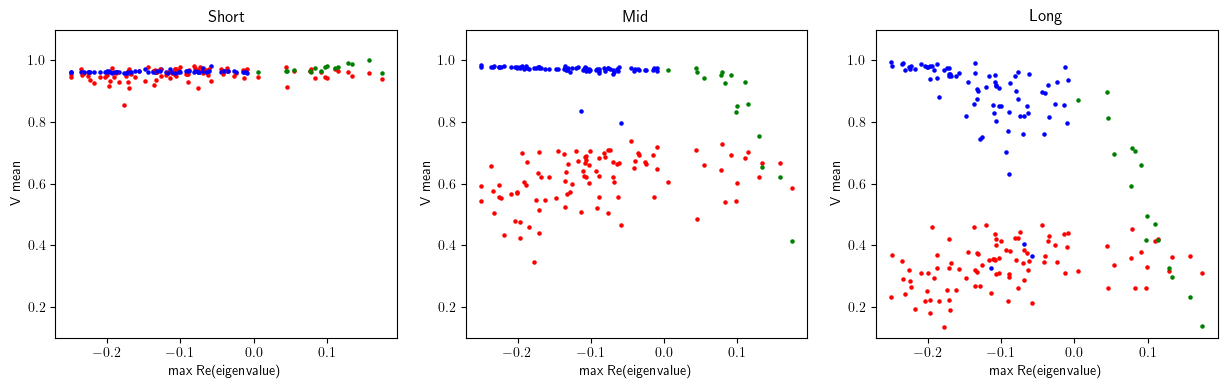

In [ ]:
#Mean
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title("Short")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("V mean")
plt.ylim(0.1, 1.1)
for i in range(96):
    plt.scatter(max_eigenvalue[i], short_range_list[i].mean(), c="red", s=5)
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], short_range_cycle_list[i].mean(), c="green", s=5)
    else:
        plt.scatter(max_eigenvalue[i], short_range_fixed_list[i].mean(), c="blue", s=5)

plt.subplot(132)
plt.title("Mid")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("V mean")
plt.ylim(0.1, 1.1)
for i in range(96):
    plt.scatter(max_eigenvalue[i], mid_range_list[i].mean(), c="red", s=5)
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], mid_range_cycle_list[i].mean(), c="green", s=5)
    else:
        plt.scatter(max_eigenvalue[i], mid_range_fixed_list[i].mean(), c="blue", s=5)

plt.subplot(133)
plt.title("Long")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("V mean")
plt.ylim(0.1, 1.1)
for i in range(96):
    plt.scatter(max_eigenvalue[i], long_range_list[i].mean(), c="red", s=5)
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], long_range_cycle_list[i].mean(), c="green", s=5)
    else:
        plt.scatter(max_eigenvalue[i], long_range_fixed_list[i].mean(), c="blue", s=5)

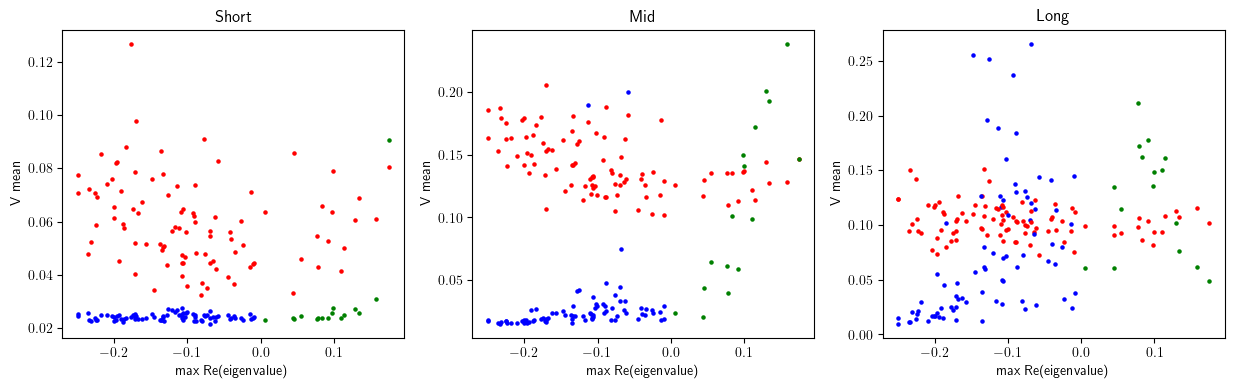

In [ ]:
#MStd
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title("Short")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("V mean")
#plt.ylim(0.1, 1.1)
for i in range(96):
    plt.scatter(max_eigenvalue[i], short_range_list[i].std(), c="red", s=5)
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], short_range_cycle_list[i].std(), c="green", s=5)
    else:
        plt.scatter(max_eigenvalue[i], short_range_fixed_list[i].std(), c="blue", s=5)

plt.subplot(132)
plt.title("Mid")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("V mean")
#plt.ylim(0.1, 1.1)
for i in range(96):
    plt.scatter(max_eigenvalue[i], mid_range_list[i].std(), c="red", s=5)
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], mid_range_cycle_list[i].std(), c="green", s=5)
    else:
        plt.scatter(max_eigenvalue[i], mid_range_fixed_list[i].std(), c="blue", s=5)

plt.subplot(133)
plt.title("Long")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("V mean")
#plt.ylim(0.1, 1.1)
for i in range(96):
    plt.scatter(max_eigenvalue[i], long_range_list[i].std(), c="red", s=5)
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], long_range_cycle_list[i].std(), c="green", s=5)
    else:
        plt.scatter(max_eigenvalue[i], long_range_fixed_list[i].std(), c="blue", s=5)

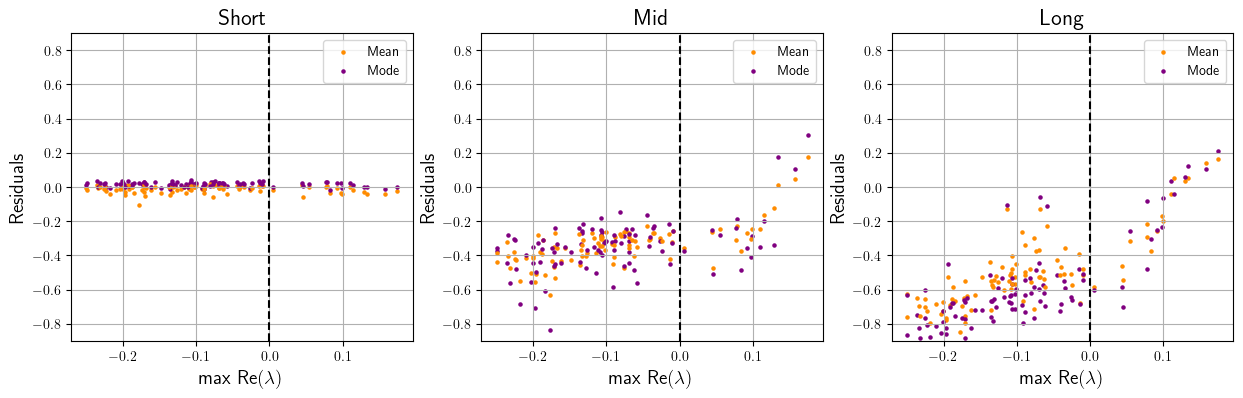

In [ ]:
#Distance between MINDy and fMRI: both mean and mod
bin = 15

color1 = "darkorange"
color2 = "purple"

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title("Short", fontsize=16)
plt.xlabel(r"max Re$(\lambda)$", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.grid()
plt.ylim(-0.9, 0.9)
plt.vlines(0, -0.9, 0.9, color="black", linestyles="dashed")
for i in range(96):
    if i == 0:
        plt.scatter(max_eigenvalue[i], short_range_list[i].mean()-np.mean(df["short_mindy"][i]), c=color1, s=5, label="Mean")
        plt.scatter(max_eigenvalue[i], get_mode(short_range_list[i], bin)-get_mode(df["short_mindy"][i], bin), c=color2, s=5, label="Mode")
    else:
        plt.scatter(max_eigenvalue[i], short_range_list[i].mean()-np.mean(df["short_mindy"][i]), c=color1, s=5)
        plt.scatter(max_eigenvalue[i], get_mode(short_range_list[i], bin)-get_mode(df["short_mindy"][i], bin), c=color2, s=5)
plt.legend()

plt.subplot(132)
plt.title("Mid", fontsize=16)
plt.xlabel(r"max Re$(\lambda)$", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.grid()
plt.ylim(-0.9, 0.9)
plt.vlines(0, -0.9, 0.9, color="black", linestyles="dashed")
for i in range(96):
    if i == 0:
        plt.scatter(max_eigenvalue[i], mid_range_list[i].mean()-np.mean(df["mid_mindy"][i]), c=color1, s=5, label="Mean")
        plt.scatter(max_eigenvalue[i], get_mode(mid_range_list[i], bin)-get_mode(df["mid_mindy"][i], bin), c=color2, s=5, label="Mode")
    else:
        plt.scatter(max_eigenvalue[i], mid_range_list[i].mean()-np.mean(df["mid_mindy"][i]), c=color1, s=5)
        plt.scatter(max_eigenvalue[i], get_mode(mid_range_list[i], bin)-get_mode(df["mid_mindy"][i], bin), c=color2, s=5)
plt.legend()

plt.subplot(133)
plt.title("Long", fontsize=16)
plt.xlabel(r"max Re$(\lambda)$", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.grid()
plt.ylim(-0.9, 0.9)
plt.vlines(0, -0.9, 0.9, color="black", linestyles="dashed")
#plt.hlines(0, min(max_eigenvalue), max(max_eigenvalue))
for i in range(96):
    if i == 0:
        plt.scatter(max_eigenvalue[i], long_range_list[i].mean()-np.mean(df["long_mindy"][i]), c=color1, s=5, label="Mean")
        plt.scatter(max_eigenvalue[i], get_mode(long_range_list[i], bin)-get_mode(df["long_mindy"][i], bin), c=color2, s=5, label="Mode")
    else:
        plt.scatter(max_eigenvalue[i], long_range_list[i].mean()-np.mean(df["long_mindy"][i]), c=color1, s=5)
        plt.scatter(max_eigenvalue[i], get_mode(long_range_list[i], bin)-get_mode(df["long_mindy"][i], bin), c=color2, s=5)
plt.legend()

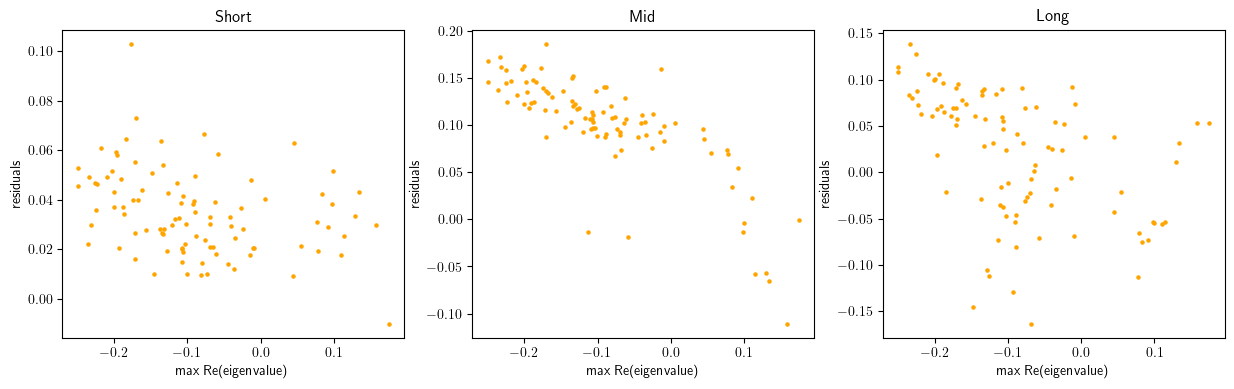

In [ ]:
#Distance between MINDy and fMRI: STD
bin = 15

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title("Short")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("residuals")
#plt.ylim(-0.6, 0.6)
#plt.vlines(0, -0.6, 0.6, color="black", linestyles="dashed")
for i in range(96):
    plt.scatter(max_eigenvalue[i], short_range_list[i].std()-np.std(df["short_mindy"][i]), c="orange", s=5)
    
plt.subplot(132)
plt.title("Mid")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("residuals")
#plt.ylim(-0.6, 0.6)
#plt.vlines(0, -0.6, 0.6, color="black", linestyles="dashed")
for i in range(96):
    plt.scatter(max_eigenvalue[i], mid_range_list[i].std()-np.std(df["mid_mindy"][i]), c="orange", s=5)
    
plt.subplot(133)
plt.title("Long")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("residuals")
#plt.ylim(-0.6, 0.6)
#plt.vlines(0, -0.6, 0.6, color="black", linestyles="dashed")
#plt.hlines(0, min(max_eigenvalue), max(max_eigenvalue))
for i in range(96):
    plt.scatter(max_eigenvalue[i], long_range_list[i].std()-np.std(df["long_mindy"][i]), c="orange", s=5)
    

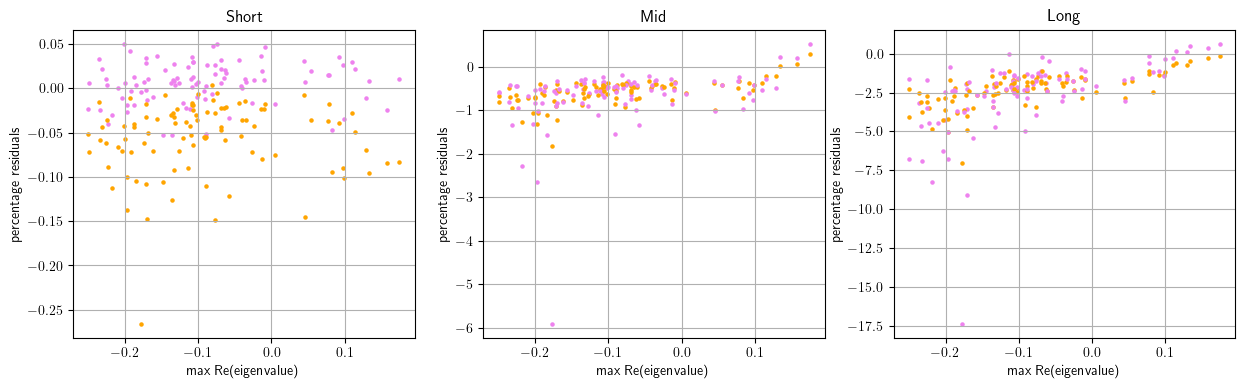

In [ ]:
#Distance % between MINDy and fMRI: both mean and mode
bin = 15

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title("Short")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("percentage residuals")
plt.grid()
for i in range(96):
    plt.scatter(max_eigenvalue[i], (short_range_list[i].mean()-np.mean(df["short_mindy"][i])/short_range_list[i].mean()), c="orange", s=5)
    plt.scatter(max_eigenvalue[i], (get_mode(short_range_list[i], bin)-get_mode(df["short_mindy"][i], bin)/ get_mode(short_range_list[i], bin)), c="violet", s=5)

plt.subplot(132)
plt.title("Mid")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("percentage residuals")
plt.grid()
for i in range(96):
    plt.scatter(max_eigenvalue[i], (mid_range_list[i].mean()-np.mean(df["mid_mindy"][i]))/mid_range_list[i].mean(), c="orange", s=5)
    plt.scatter(max_eigenvalue[i], (get_mode(mid_range_list[i], bin)-get_mode(df["mid_mindy"][i], bin))/get_mode(mid_range_list[i], bin), c="violet", s=5)

plt.subplot(133)
plt.title("Long")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("percentage residuals")
plt.grid()
#plt.hlines(0, min(max_eigenvalue), max(max_eigenvalue))
for i in range(96):
    plt.scatter(max_eigenvalue[i], (long_range_list[i].mean()-np.mean(df["long_mindy"][i])/long_range_list[i].mean()), c="orange", s=5)
    plt.scatter(max_eigenvalue[i], (get_mode(long_range_list[i], bin)-get_mode(df["long_mindy"][i], bin))/get_mode(long_range_list[i], bin), c="violet", s=5)


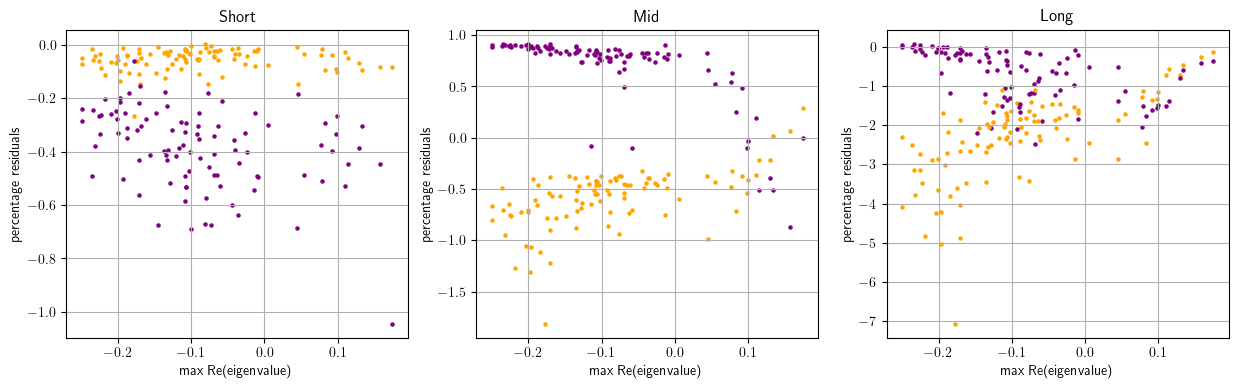

In [ ]:
#Distance % between MINDy and fMRI: both mean and std
bin = 15

color2 = "purple"

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title("Short")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("percentage residuals")
plt.grid()
for i in range(96):
    plt.scatter(max_eigenvalue[i], (short_range_list[i].mean()-np.mean(df["short_mindy"][i])/short_range_list[i].mean()), c="orange", s=5)
    plt.scatter(max_eigenvalue[i], (short_range_list[i].std()-np.std(df["short_mindy"][i])/short_range_list[i].std()), c=color2, s=5)
    
plt.subplot(132)
plt.title("Mid")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("percentage residuals")
plt.grid()
for i in range(96):
    plt.scatter(max_eigenvalue[i], (mid_range_list[i].mean()-np.mean(df["mid_mindy"][i]))/mid_range_list[i].mean(), c="orange", s=5)
    plt.scatter(max_eigenvalue[i], (mid_range_list[i].std()-np.std(df["mid_mindy"][i]))/mid_range_list[i].std(), c=color2, s=5)
    

plt.subplot(133)
plt.title("Long")
plt.xlabel("max Re(eigenvalue)")
plt.ylabel("percentage residuals")
plt.grid()
#plt.hlines(0, min(max_eigenvalue), max(max_eigenvalue))
for i in range(96):
    plt.scatter(max_eigenvalue[i], (long_range_list[i].mean()-np.mean(df["long_mindy"][i])/long_range_list[i].mean()), c="orange", s=5)
    plt.scatter(max_eigenvalue[i], (long_range_list[i].std()-np.std(df["long_mindy"][i])/long_range_list[i].std()), c=color2, s=5)
    

C:\Users\paolo\AppData\Local\Temp\ipykernel_8040\618265382.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12, 8, i+1, facecolor=(0.48,0.9, 0, 0.5))


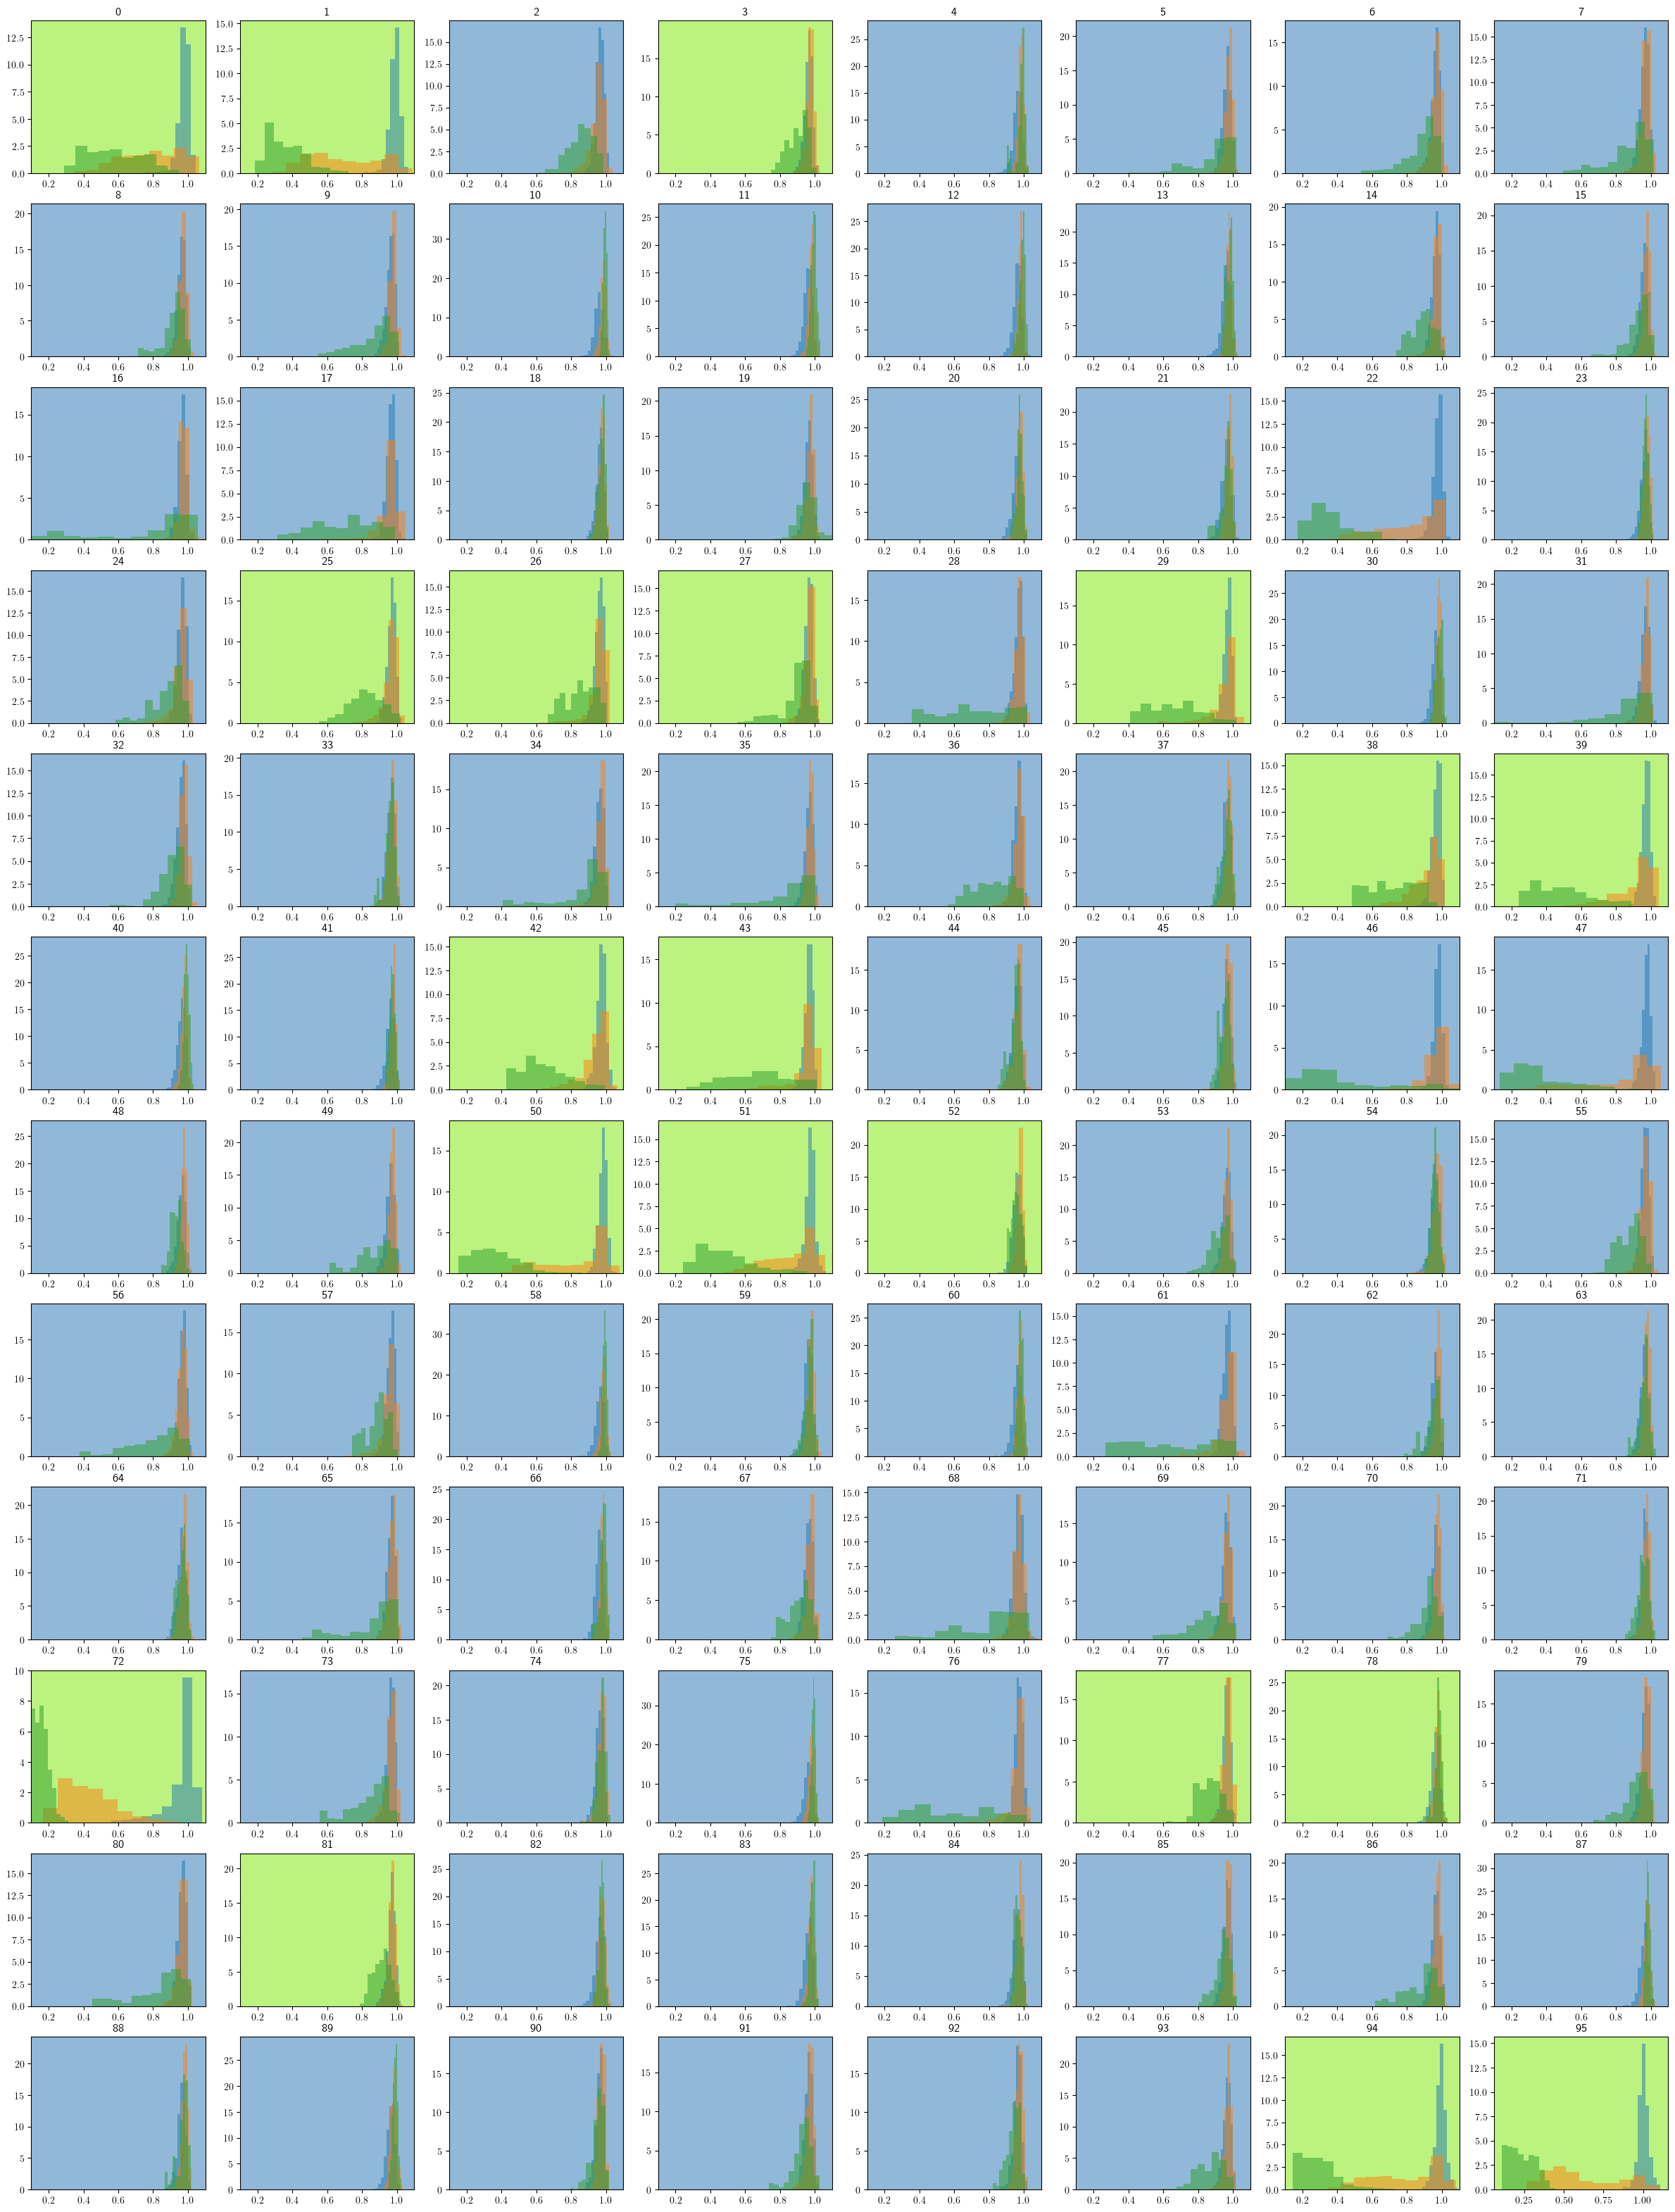

In [ ]:
plt.figure(figsize=(30, 40))
for i in range(96):
    #data, W, alpha, D = load_param(i)
    #simul = propagation(W, alpha, D, 0)

    if classification[i] == 0:
        plt.xlim(0.1, 1.1)
        plt.subplot(12, 8, i+1, facecolor=(0.48,0.9, 0, 0.5))
        plt.hist(short_range_cycle_list[i], alpha=0.5, density=True)
        plt.hist(mid_range_cycle_list[i], alpha=0.5, density=True)
        plt.hist(long_range_cycle_list[i], alpha=0.5, density=True)
        plt.title(str(i))

    if classification[i] == 1:
        plt.xlim(0.1, 1.1)
        plt.subplot(12, 8, i+1, facecolor=(0.14, 0.45, 0.7, 0.5))
        plt.hist(short_range_fixed_list[i], alpha=0.5, density=True)
        plt.hist(mid_range_fixed_list[i], alpha=0.5, density=True)
        plt.hist(long_range_fixed_list[i], alpha=0.5, density=True)
        plt.title(str(i))
    


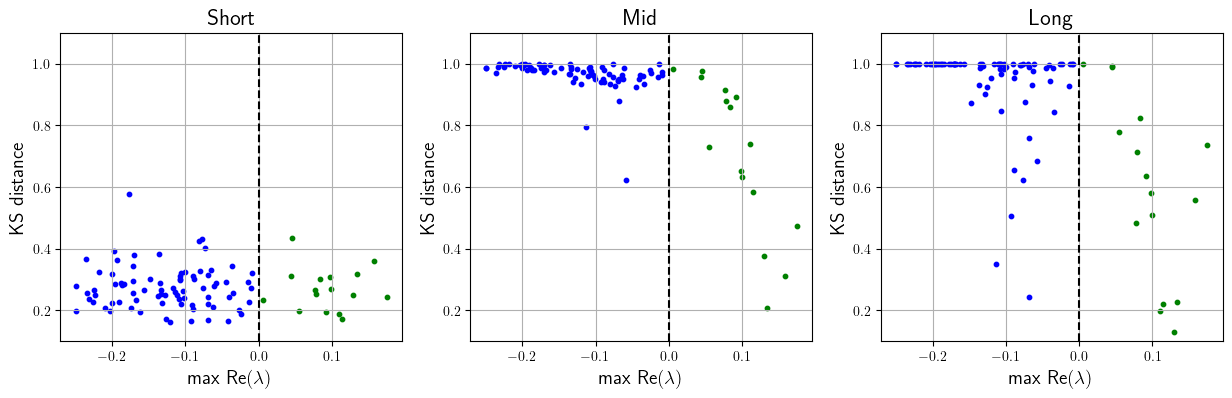

In [ ]:
from scipy.stats import kstest

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.title("Short", fontsize=16)
plt.xlabel(r"max Re$(\lambda)$", fontsize=14)
plt.ylabel("KS distance", fontsize=14)
plt.grid()
plt.vlines(0, 0.1, 1.1, color="black", linestyles="dashed")
plt.ylim(0.1, 1.1)
for i in range(96):
    ks = kstest(df["short_mindy"][i], df["short"][i])[0]
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], ks, c="green", s=10)
    else:
        plt.scatter(max_eigenvalue[i], ks, c="blue", s=10)

plt.subplot(132)
plt.title("Mid", fontsize=16)
plt.xlabel(r"max Re$(\lambda)$", fontsize=14)
plt.ylabel("KS distance", fontsize=14)
plt.grid()
plt.vlines(0, 0.1, 1.1, color="black", linestyles="dashed")
plt.ylim(0.1, 1.1)
for i in range(96):
    ks = kstest(df["mid_mindy"][i], df["mid"][i])[0]
    #ks = kstest(m_range_2[i], df["mid"][i])[0]
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], ks, c="green", s=10)
    else:
        plt.scatter(max_eigenvalue[i], ks, c="blue", s=10)

plt.subplot(133)
plt.title("Long", fontsize=16)
plt.xlabel(r"max Re$(\lambda)$", fontsize=14)
plt.ylabel("KS distance", fontsize=14)
plt.grid()
plt.vlines(0, 0.1, 1.1, color="black", linestyles="dashed")
plt.ylim(0.1, 1.1)
for i in range(96):
    ks = kstest(df["long_mindy"][i], df["long"][i])[0]
    if classification[i] == 0:
        plt.scatter(max_eigenvalue[i], ks, c="green", s=10)
    else:
        plt.scatter(max_eigenvalue[i], ks, c="blue", s=10)

C:\Users\paolo\AppData\Local\Temp\ipykernel_8040\3145573105.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(12, 8, i+1, facecolor=(0.48,0.9, 0, 0.5))


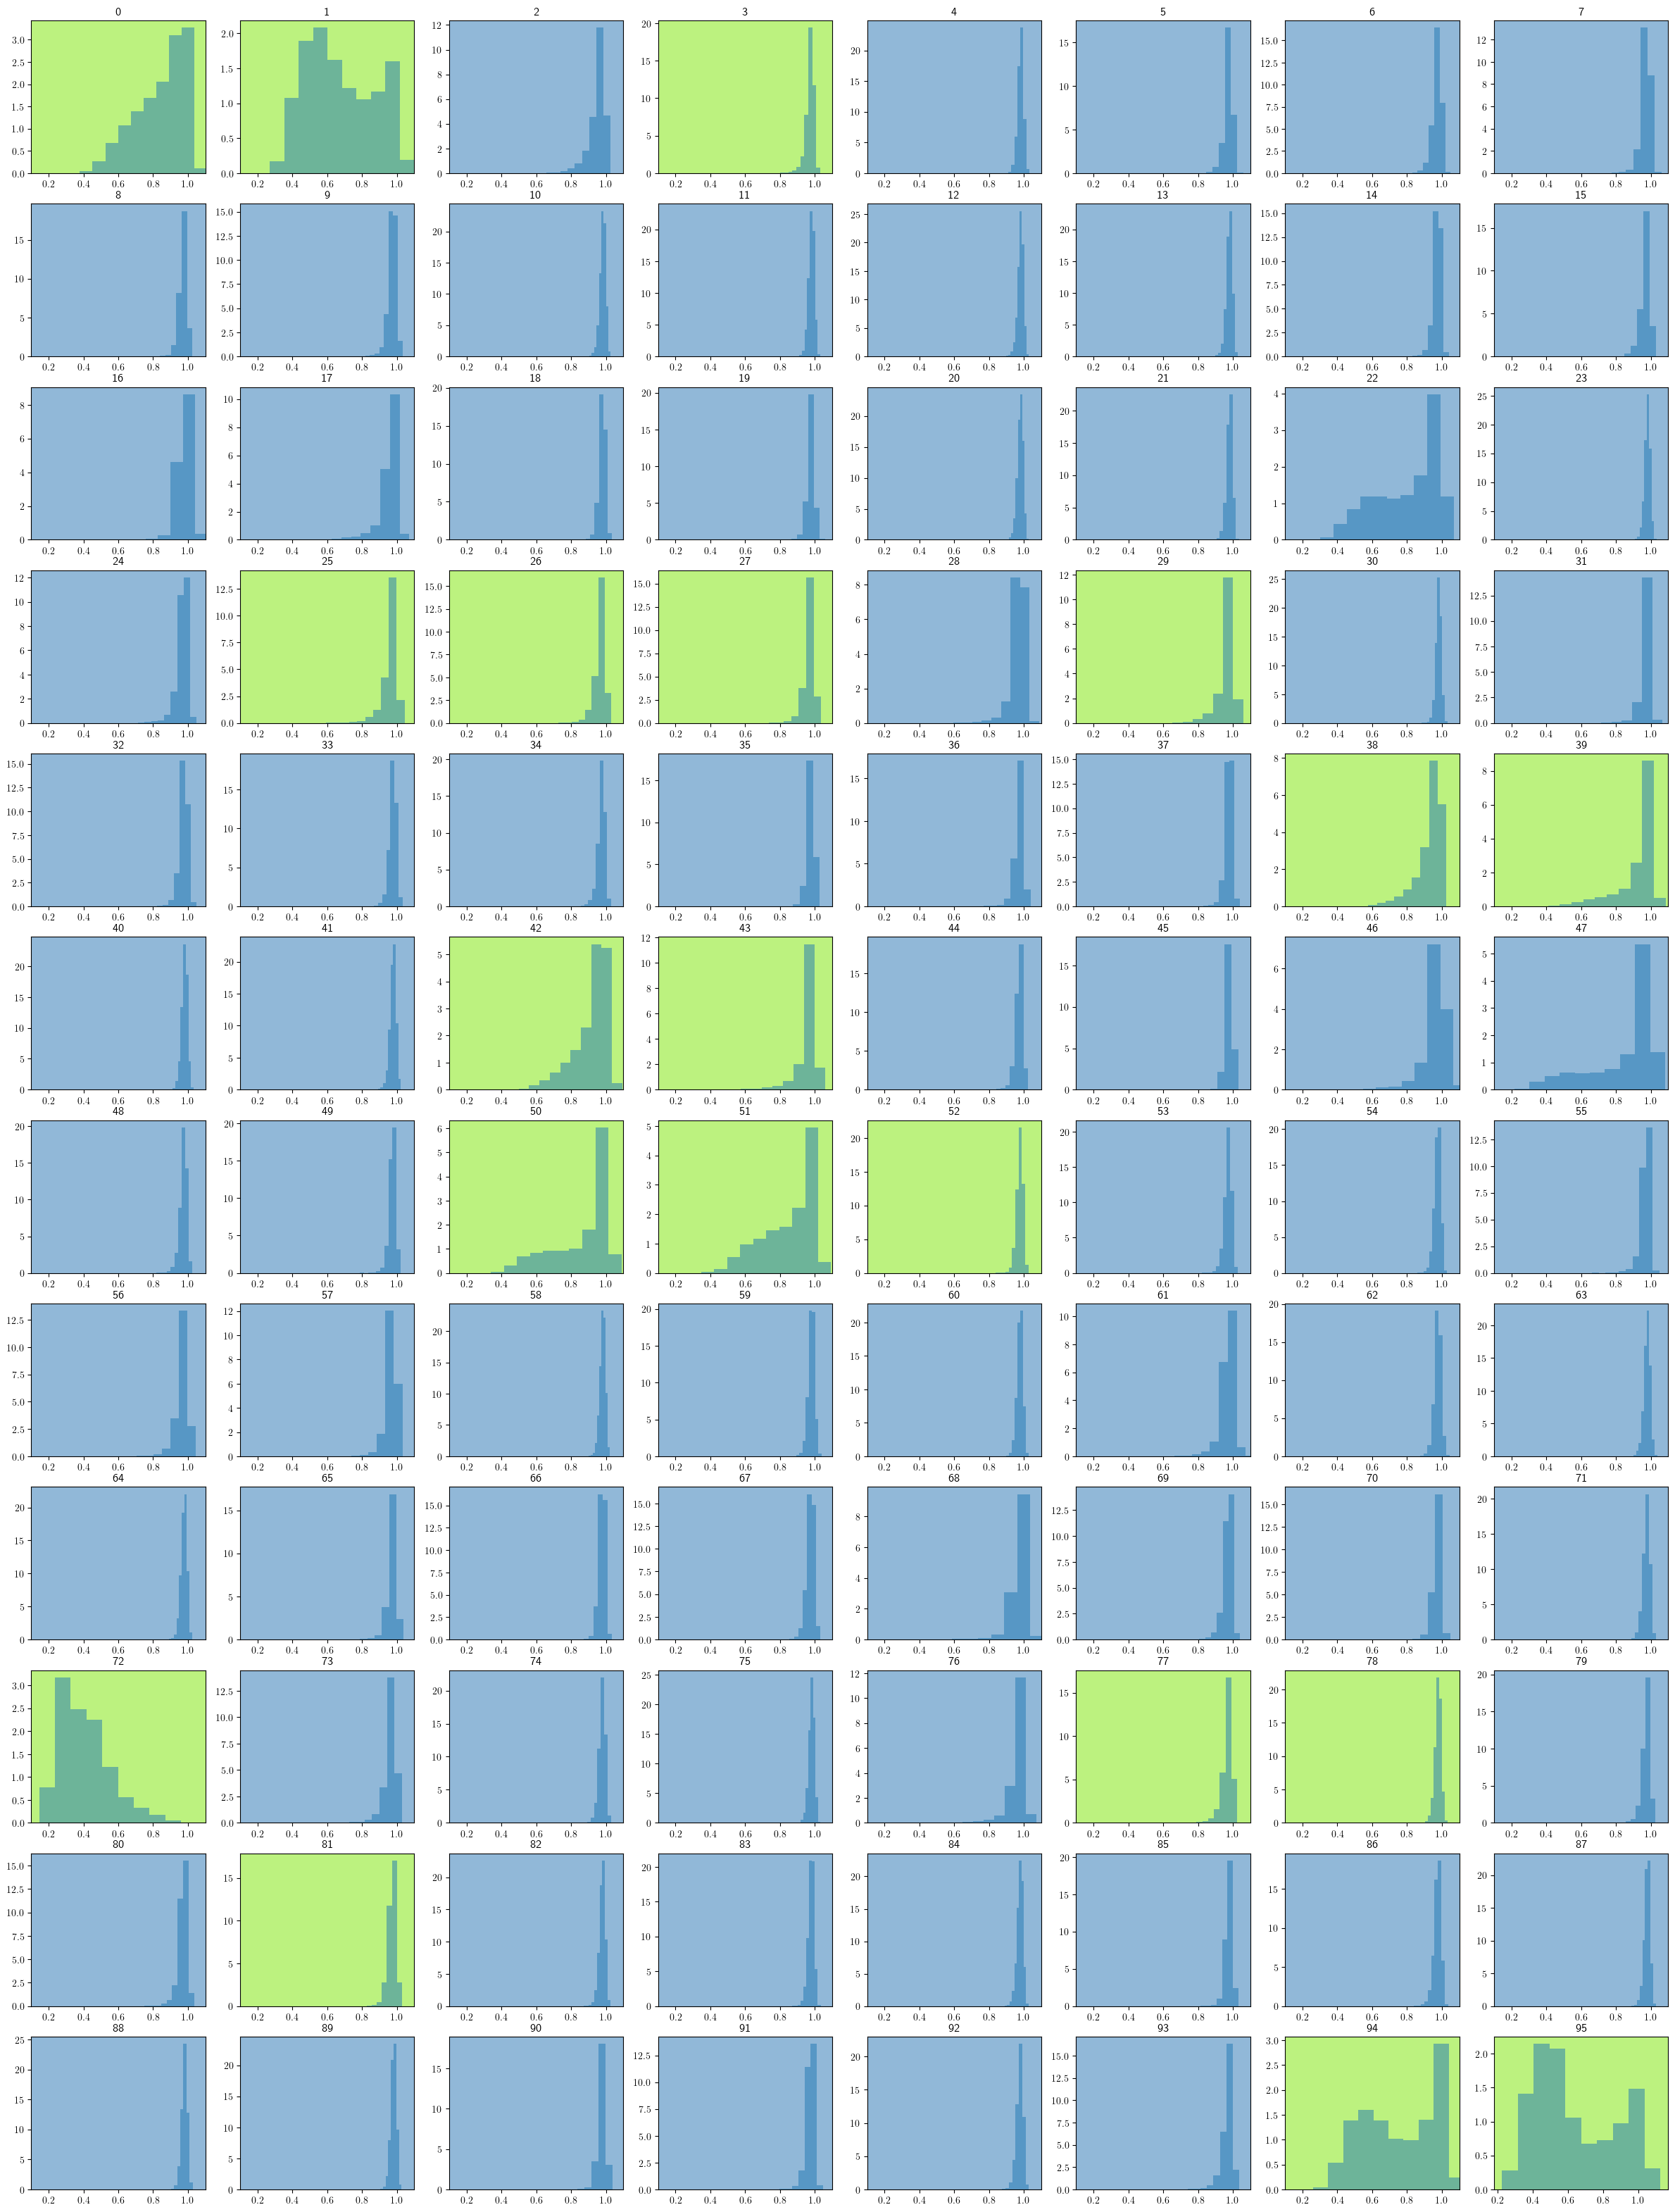

In [ ]:
plt.figure(figsize=(30, 40))
for i in range(96):
    data, W, alpha, D = load_param(i)
    simul = propagation(W, alpha, D, 0)

    if classification[i] == 0:
        plt.xlim(0.1, 1.1)
        plt.subplot(12, 8, i+1, facecolor=(0.48,0.9, 0, 0.5))
        plt.hist(m_range_2[i], alpha=0.5, density=True)
        plt.title(str(i))

    if classification[i] == 1:
        plt.xlim(0.1, 1.1)
        plt.subplot(12, 8, i+1, facecolor=(0.14, 0.45, 0.7, 0.5))
        plt.hist(m_range_2[i], alpha=0.5, density=True)
        plt.title(str(i))

### Eigenvalues

In [ ]:
def find_period_fft(data, sampling_rate):
    n = len(data)
    fft_result = np.fft.fft(data)
    freqs = np.fft.fftfreq(n, d=1/sampling_rate)
    amplitude = np.abs(fft_result)
    
    # Remove the DC component (if present) since it can interfere with period detection
    amplitude[0] = 0
    
    dominant_frequency = np.argmax(amplitude)
    period = 1 / np.abs(freqs[dominant_frequency])
    return period

def points_before_convergence(time_series, fixed_point):
    tolerance = 1e-6
    for i, value in enumerate(time_series):
        if np.abs(value - fixed_point) < tolerance:
            return i + 1
    return -1  # Indicates that convergence did not occur within the tolerance

In [ ]:
how_fast = []

for i in range(96):
    data, W, alpha, D = load_param(i)
    simul = propagation(W, alpha, D, 0)

    if classification[i] == 0:
        periods = []
        for j in range(119):
            periods.append(find_period_fft(simul[i], 1))
        how_fast.append(periods)
    if classification[i] == 1:
        convergence_rates = []
        for j in range(119):
            fixed_point = simul[i][-20:].mean()
            convergence_rates.append(points_before_convergence(simul[i], fixed_point))
        how_fast.append(convergence_rates)

In [ ]:
df = pd.DataFrame({"class" : classification, "eigenvalue" : max_eigenvalue})

In [ ]:
df["how_fast"] = how_fast

In [ ]:
for i in range(len(how_fast)):
    df["how_fast"][i] = np.mean(np.array(how_fast[i]))

C:\Users\paolo\AppData\Local\Temp\ipykernel_20064\3442824059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["how_fast"][i] = np.mean(np.array(how_fast[i]))


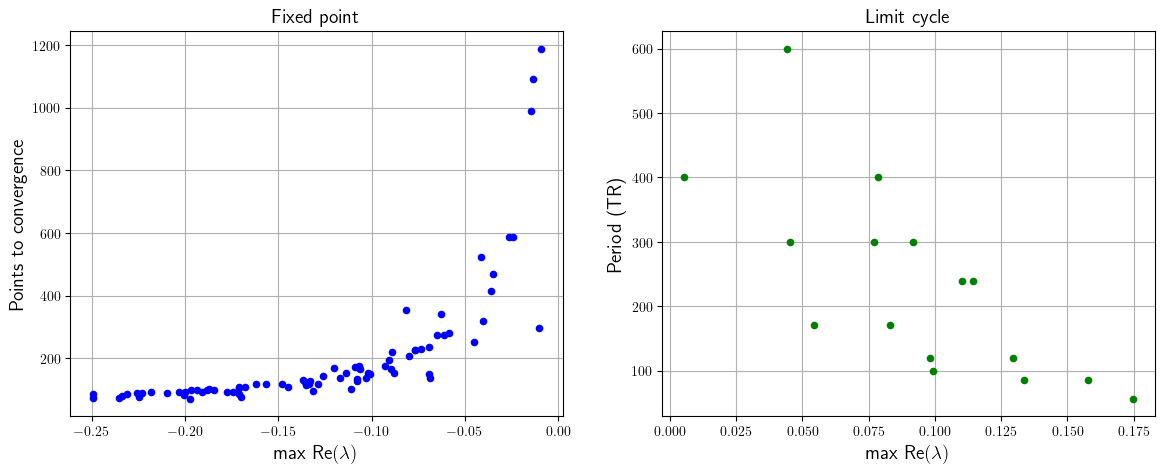

In [ ]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plt.title("Fixed point", fontsize=14)
plt.xlabel(r"max Re$(\lambda)$", fontsize=14)
plt.ylabel("Points to convergence", fontsize=14)
plt.grid()
df_fixed = df[df["class"] == 1]
plt.scatter(df_fixed["eigenvalue"], df_fixed["how_fast"], s=20, c="blue", zorder=10)


plt.subplot(122)
plt.title("Limit cycle", fontsize=14)
plt.xlabel(r"max Re$(\lambda)$", fontsize=14)
plt.ylabel("Period (TR)", fontsize=14)
plt.grid()
df_cycle = df[df["class"] == 0]
plt.scatter(df_cycle["eigenvalue"], df_cycle["how_fast"], s=20, c="green", zorder=10)

In [ ]:
classification[5]

1

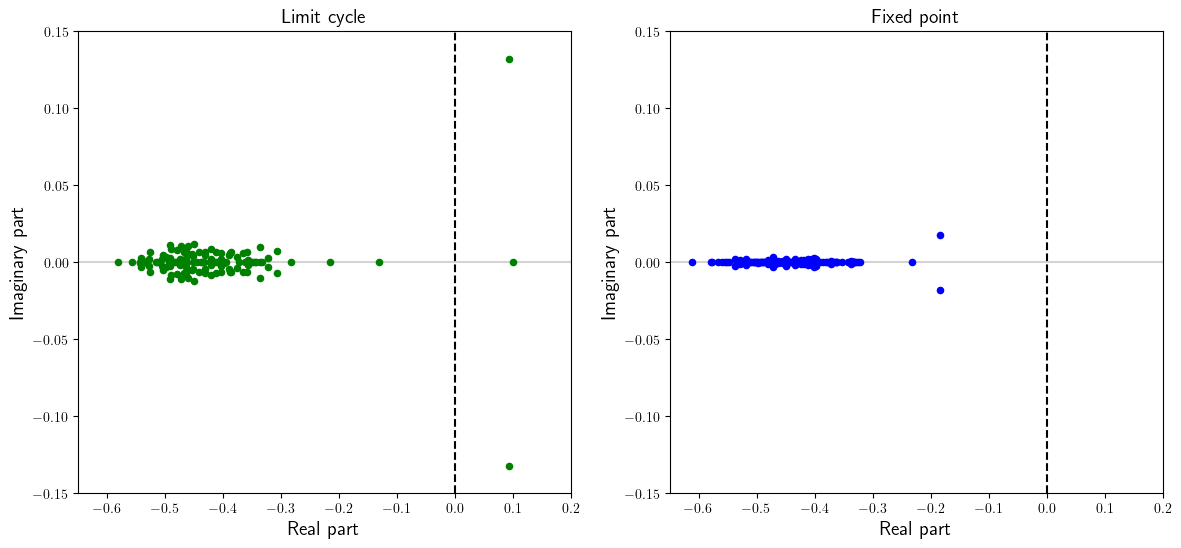

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.xlim(-0.65, 0.2)
plt.ylim(-0.15, 0.15)
#plt.grid()
plt.vlines(0, -0.15, 0.15, color="black", linestyles="dashed")
plt.hlines(0, -0.65, 0.2, color="lightgrey", zorder=0)
plt.xlabel("Real part", fontsize=14)
plt.ylabel("Imaginary part", fontsize=14)
plt.title("Limit cycle", fontsize=14)

data, W, alpha, D = load_param(0)
simul = propagation(W, alpha, D, 0)

J_psi = np.diag(d_psi(alpha, b, 0))
A_tilde = np.dot(W, J_psi) - np.identity(119)*D
eigen = np.linalg.eig(A_tilde)[0]

plt.scatter(eigen.real, eigen.imag, c="green", s=20)


plt.subplot(122)
plt.xlim(-0.65, 0.2)
plt.ylim(-0.15, 0.15)
#plt.grid()
plt.vlines(0, -0.15, 0.15, color="black", linestyles="dashed")
plt.hlines(0, -0.65, 0.2, color="lightgrey", zorder=0)
plt.xlabel("Real part", fontsize=14)
plt.ylabel("Imaginary part", fontsize=14)
plt.title("Fixed point", fontsize=14)

data, W, alpha, D = load_param(5)
simul = propagation(W, alpha, D, 0)

x_tilde = simul[-10:].mean()
J_psi = np.diag(d_psi(alpha, b, x_tilde))
A_tilde = np.dot(W, J_psi) - np.identity(119)*D
eigen = np.linalg.eig(A_tilde)[0]

plt.scatter(eigen.real, eigen.imag, c="blue", s=20)


### Distances for sigma=0

In [18]:
data, W, alpha, D = load_param(2)
simul = propagation(W, alpha, D, 0)

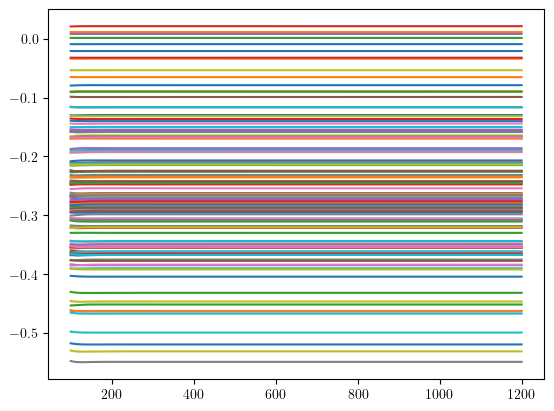

In [28]:
plt.plot(simul[100:])

(array([ 82.,  30.,  32.,  22.,  26.,  35.,  38., 113., 303.,  99.]),
 array([1.35068090e-04, 9.25120845e-02, 1.84889101e-01, 2.77266117e-01,
        3.69643134e-01, 4.62020150e-01, 5.54397166e-01, 6.46774183e-01,
        7.39151199e-01, 8.31528215e-01, 9.23905232e-01]),
 <BarContainer object of 10 artists>)

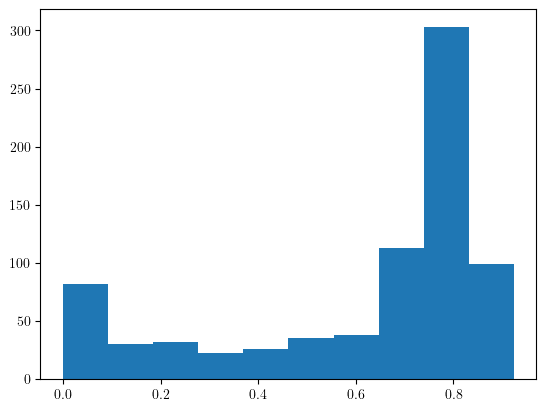

In [20]:
v_dist = pooled_v_stream(simul[100:], 21, 82)
plt.hist(v_dist)

(array([5., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.02529271, 0.05764943, 0.09000614, 0.12236286, 0.15471958,
        0.18707629, 0.21943301, 0.25178972, 0.28414644, 0.31650315,
        0.34885987]),
 <BarContainer object of 10 artists>)

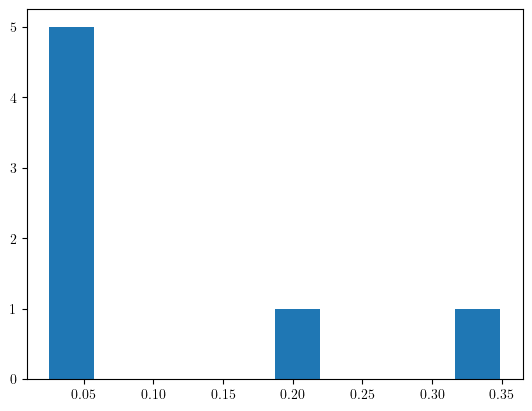

In [22]:
v_dist = pooled_v_stream(simul[100:], 82, 82)
plt.hist(v_dist)

<AxesSubplot: >

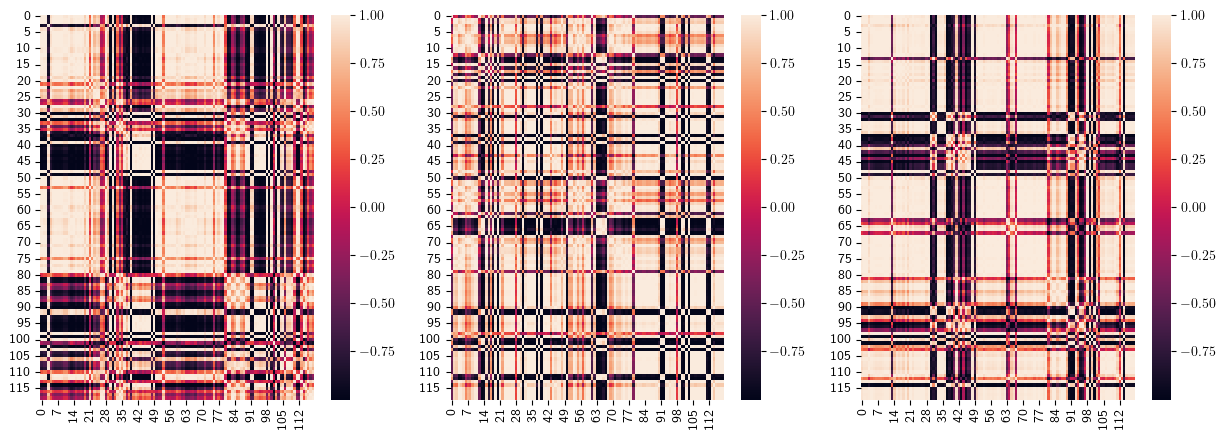

In [35]:
#Why there are changes in the FC also when the time series are flat?!?!?!?!?
plt.figure(figsize=(15, 5))
plt.subplot(131)
sn.heatmap(FC(t=100, tau=40, data=simul[100:]))
plt.subplot(132)
sn.heatmap(FC(t=150, tau=40, data=simul[100:]))
plt.subplot(133)
sn.heatmap(FC(t=200, tau=40, data=simul[100:]))

In [39]:
data = simul[100:]
data.head()

0         1         2         3         4         5         6    \
100 -0.246571 -0.350983 -0.246420 -0.223814 -0.281464 -0.294057 -0.243601   
101 -0.246554 -0.350981 -0.246402 -0.223959 -0.281541 -0.294066 -0.243577   
102 -0.246536 -0.350973 -0.246378 -0.224094 -0.281609 -0.294068 -0.243550   
103 -0.246516 -0.350961 -0.246350 -0.224220 -0.281667 -0.294064 -0.243521   
104 -0.246497 -0.350944 -0.246317 -0.224337 -0.281717 -0.294054 -0.243489   

          7         8         9    ...       109       110       111  \
100 -0.356728 -0.321467 -0.189764  ... -0.115972 -0.020734 -0.033811   
101 -0.356698 -0.321434 -0.189765  ... -0.116007 -0.020739 -0.033804   
102 -0.356662 -0.321397 -0.189763  ... -0.116040 -0.020743 -0.033798   
103 -0.356623 -0.321356 -0.189757  ... -0.116070 -0.020747 -0.033791   
104 -0.356579 -0.321311 -0.189749  ... -0.116098 -0.020751 -0.033785   

          112       113       114       115       116       117       118  
100 -0.090454 -0.032005  0.008331 -0.098426 -0.167187 -0.158014 -0.131202  
101 -0.090419 -0.032018  0.008330 -0.098475 -0.167251 -0.158095 -0.131263  
102 -0.090386 -0.032029  0.008329 -0.098522 -0.167309 -0.158169 -0.131320  
103 -0.090354 -0.032040  0.008328 -0.098564 -0.167363 -0.158237 -0.131371  
104 -0.090324 -0.032049  0.008327 -0.098604 -0.167411 -0.158299 -0.131418  

[5 rows x 119 columns]

In [40]:
t = 100
tau = 40
data_window = data[int((t-tau/2)):int((t+tau/2))]
data_window.head()

0         1         2         3         4         5         6    \
180 -0.245932 -0.349568 -0.244630 -0.225148 -0.281037 -0.292572 -0.242325   
181 -0.245933 -0.349569 -0.244631 -0.225146 -0.281036 -0.292572 -0.242326   
182 -0.245933 -0.349570 -0.244632 -0.225144 -0.281036 -0.292573 -0.242327   
183 -0.245934 -0.349570 -0.244633 -0.225142 -0.281035 -0.292574 -0.242328   
184 -0.245935 -0.349571 -0.244634 -0.225140 -0.281035 -0.292574 -0.242329   

          7         8         9    ...       109       110       111  \
180 -0.354697 -0.319522 -0.188944  ... -0.116300 -0.020759 -0.033671   
181 -0.354698 -0.319523 -0.188944  ... -0.116299 -0.020759 -0.033671   
182 -0.354700 -0.319524 -0.188945  ... -0.116299 -0.020759 -0.033671   
183 -0.354701 -0.319526 -0.188945  ... -0.116298 -0.020759 -0.033672   
184 -0.354703 -0.319527 -0.188946  ... -0.116298 -0.020759 -0.033672   

          112       113       114       115       116       117       118  
180 -0.089974 -0.032059  0.008306 -0.098805 -0.167476 -0.158458 -0.131500  
181 -0.089974 -0.032059  0.008306 -0.098804 -0.167475 -0.158457 -0.131499  
182 -0.089975 -0.032059  0.008306 -0.098804 -0.167474 -0.158456 -0.131498  
183 -0.089976 -0.032059  0.008306 -0.098803 -0.167474 -0.158455 -0.131497  
184 -0.089977 -0.032059  0.008306 -0.098803 -0.167473 -0.158454 -0.131497  

[5 rows x 119 columns]

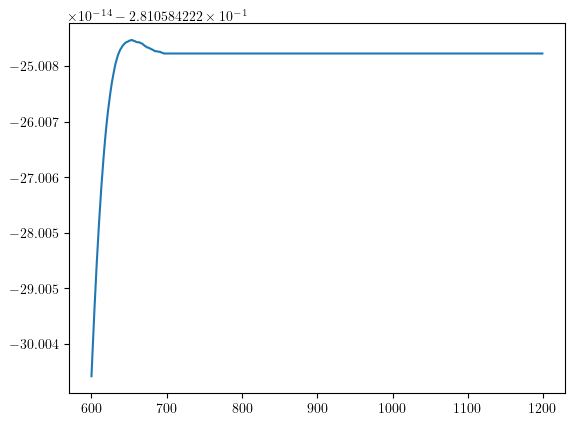

In [46]:
plt.plot(simul[600:][4])

In [25]:
short_without_starting = []

for i in range(96):
    if classification[i] == 1:
        subject, W, alpha, D = load_param(i)
        subject = subject.apply(zscore)
        v_subject = pooled_v_stream(subject, 8, 20)

        simul = propagation(W, alpha, D, 0)[200:]
        v_simul = pooled_v_stream(simul, 8, 20)[200:]

        ks = kstest(v_subject, v_simul)[0]
        short_without_starting.append(ks)


In [23]:
table_short = np.load("table_short.npy")

In [27]:
short_fixed = []

for i in range(96):
    if classification[i] == 1:
        short_fixed.append(table_short[0, i])
        

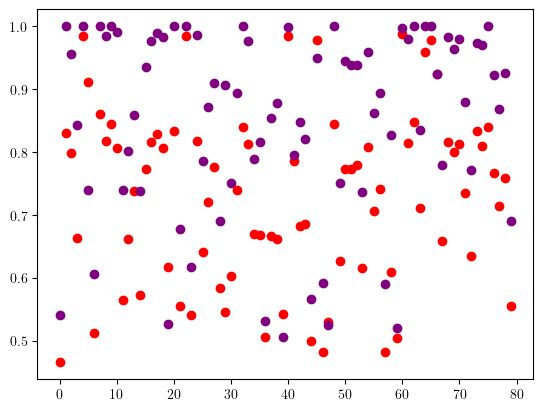

In [29]:
for i in range(len(short_fixed)):
    plt.scatter(i, short_fixed[i], c="red")
    plt.scatter(i, short_without_starting[i], c="purple")
    

### Sigma and dynamics

In [ ]:
sigma = np.linspace(0, 0.7, 10)

In [ ]:
table_short = np.zeros((len(sigma), 96))

for j in range(len(sigma)):
    print(j)
    for i in range(96):
        subject, W, alpha, D = load_param(i)
        subject = subject.apply(zscore)
        v_subject = pooled_v_stream(subject, 8, 20)
        
        simul = propagation(W, alpha, D, sigma[j])
        v_simul = pooled_v_stream(simul, 8, 20)
        
        ks = kstest(v_subject, v_simul)[0]

        table_short[j, i] = ks

0
1
2
3
4
5
6
7
8
9


In [ ]:
np.save("table_short.npy", table_short)

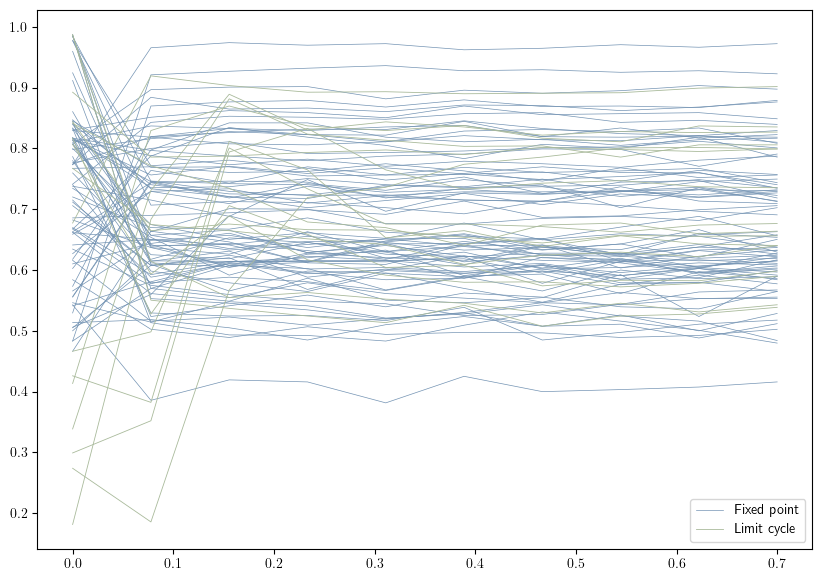

In [ ]:
plt.figure(figsize=(10, 7))
#plt.xlabel(r"$\sigma$")
#plt.ylabel(r"$\mathrm{Corr}(\mathrm{FC}_{\mathrm{MINDy}}, \mathrm{FC})$")

legend_fixed = False
legend_cycle = False

line = 0.5
alpha = 1
for i in range(96):
    if classification[i] == 1:
        if legend_fixed == False:
            plt.plot(sigma, table_short[:, i], lw=line, color="#7393B3", alpha=alpha, label="Fixed point")
            legend_fixed = True
        else:
            plt.plot(sigma, table_short[:, i], lw=line, color="#7393B3", alpha=alpha)
for i in range(96):
    if classification[i] == 0:
        if legend_cycle == False:
            plt.plot(sigma, table_short[:, i], lw=1.2*line, color="#A9BA9B", alpha=alpha, label="Limit cycle")
            legend_cycle = True
        else:
            plt.plot(sigma, table_short[:, i], lw=1.2*line, color="#A9BA9B", alpha=alpha)

plt.legend()

In [ ]:
table_mid = np.zeros((len(sigma), 96))

for j in range(len(sigma)):
    print(j)
    for i in range(96):
        subject, W, alpha, D = load_param(i)
        subject = subject.apply(zscore)
        v_subject = pooled_v_stream(subject, 21, 82)
        
        simul = propagation(W, alpha, D, sigma[j])
        v_simul = pooled_v_stream(simul, 21, 82)
        
        ks = kstest(v_subject, v_simul)[0]

        table_mid[j, i] = ks

0
1
2
3
4
5
6
7
8
9


In [ ]:
np.save("table_mid.npy", table_mid)

In [ ]:
table_long = np.zeros((len(sigma), 96))

for j in range(len(sigma)):
    print(j)
    for i in range(96):
        subject, W, alpha, D = load_param(i)
        subject = subject.apply(zscore)
        v_subject = pooled_v_stream(subject, 83, 290)
        
        simul = propagation(W, alpha, D, sigma[j])
        v_simul = pooled_v_stream(simul, 83, 290)
        
        ks = kstest(v_subject, v_simul)[0]

        table_long[j, i] = ks

0
1
2
3
4
5
6
7
8
9


In [ ]:
np.save("table_long.npy", table_long)

In [52]:
noise = np.zeros((1200, 119))
for i in range(1200):
    noise[i, :] = np.random.normal(0, 0.5, 119)
noise = pd.DataFrame(noise)

In [53]:
noise

0         1         2         3         4         5         6    \
0     0.063568 -0.232132  1.073294 -1.229626 -0.556628  0.209723  0.308322   
1     0.250099 -0.993514 -0.423339  0.181009  0.481746  0.153420 -0.043279   
2    -0.102819 -0.100115 -0.060317  0.234239  0.410385  0.005338  0.639246   
3     0.133357 -0.563255 -0.093296 -0.020130  0.773750 -0.116342 -0.427997   
4     0.009451  0.214200 -0.570449 -0.324802  0.198458  0.485947  0.451214   
...        ...       ...       ...       ...       ...       ...       ...   
1195  0.802732  0.803676  0.270920 -0.224582  0.965756 -0.407095  0.031007   
1196 -0.037108 -0.231265 -0.158937 -0.095559 -0.319576 -0.246677  0.888598   
1197  0.434065  0.535987 -0.293176  0.638025 -0.249009 -0.058995 -0.935934   
1198  0.726966  0.222471  0.266064  0.426908  0.288379 -0.070752 -0.527395   
1199  0.362476  0.018952 -0.828601 -0.241188 -0.182634 -0.932930  0.533387   

           7         8         9    ...       109       110       111  \
0    -0.623081 -1.001220  0.480928  ... -0.315727 -0.361607  0.799521   
1     0.161517  0.532852  0.382799  ... -0.001982  0.388908 -0.791334   
2     0.394886 -0.200289  0.077990  ...  0.291123 -0.907032 -0.633591   
3    -0.107915 -0.294243 -0.211533  ... -0.130416 -0.346735 -0.287297   
4    -0.867607  0.726831 -0.864058  ...  0.457902 -0.171786 -0.505039   
...        ...       ...       ...  ...       ...       ...       ...   
1195  0.467114 -0.082076  0.462726  ... -0.396621  0.772998  0.218526   
1196  0.070388  0.673754  0.078969  ...  0.054195  0.498516  0.274294   
1197 -0.069779  0.410523  0.302909  ... -0.482601 -0.282693 -0.619004   
1198 -0.455638  0.173347  0.098646  ... -0.125975  0.011440 -0.021473   
1199 -0.471901  0.030116  0.362792  ... -0.055941  0.426069 -0.829966   

           112       113       114       115       116       117       118  
0    -0.316000  0.918496  0.302313 -0.023949  0.207346 -0.457744 -0.059596  
1     0.076977  0.750899 -0.581287 -0.429457  0.193957 -0.694591  0.367419  
2     0.057670 -0.327949 -0.417999 -0.743167  0.005017 -1.190878  0.401704  
3    -0.056400 -0.446490 -0.061209 -0.760315  0.735502 -1.083166 -0.079352  
4    -0.086566  0.283492 -0.898748  0.035342 -0.674088 -0.513331 -0.127345  
...        ...       ...       ...       ...       ...       ...       ...  
1195  0.341939  0.389109 -0.229032 -0.337511 -0.038879 -0.185373  0.427489  
1196 -0.511105  0.598019 -0.215386 -0.425677 -0.597173  0.025063 -0.230704  
1197  0.242840 -0.642041 -0.957633 -0.722681  0.623203 -0.166395 -0.187432  
1198 -0.164947  0.044871  0.354351  0.708817 -0.421917  0.704323 -0.285617  
1199 -1.077578 -0.093144  0.407990 -0.077136 -0.267580  0.106648 -0.210244  

[1200 rows x 119 columns]

In [54]:
v_noise = pooled_v_stream(noise, 20, 50)

(array([  2.,  22.,  49., 125., 242., 300., 229.,  88.,  34.,   9.]),
 array([0.96262692, 0.96985519, 0.97708347, 0.98431174, 0.99154001,
        0.99876829, 1.00599656, 1.01322484, 1.02045311, 1.02768139,
        1.03490966]),
 <BarContainer object of 10 artists>)

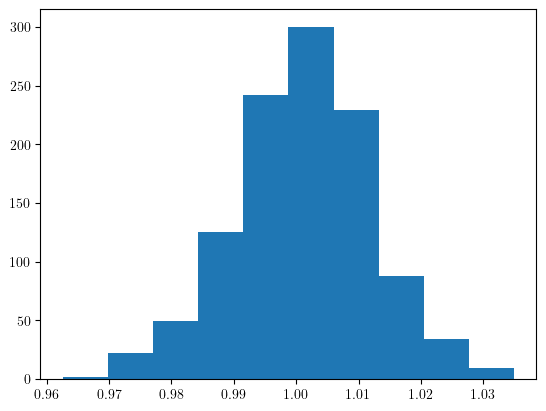

In [55]:
plt.hist(v_noise)